In [1]:
%load_ext autoreload
%autoreload 2

# Conditional VAE for genetic circuits

This notebook follows the previous VAE notebook very closely, but implementing a conditional VAE instead. Loosely following [this blog post](https://agustinus.kristia.de/techblog/2016/12/17/conditional-vae/) with the associated [github](https://github.com/wiseodd/generative-models/blob/master/VAE/conditional_vae/cvae_pytorch.py).

## Imports 

In [2]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.data.data_format_tools.common import write_json
from functools import partial

from sklearn.metrics import r2_score
import os

USE_ONLY_ONE_GPU = True
if USE_ONLY_ONE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # 0 or 1

import sys
import numpy as np
import haiku as hk
import jax
import optax

import wandb

from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'gpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)

PRNG = jax.random.PRNGKey(0)

jax.devices()

# jupyter nbconvert --to notebook --execute 01_cvae.ipynb --output=01_cvae_2.ipynb --ExecutePreprocessor.timeout=-1




[cuda(id=0)]

In [3]:
from evoscaper.model.vae import VAE_fn
from evoscaper.model.shared import get_activation_fn
from evoscaper.model.loss import loss_wrapper, compute_accuracy_regression, mse_loss, accuracy_regression
from evoscaper.utils.math import bin_to_nearest_edge, arrayise
from evoscaper.utils.optimiser import make_optimiser
from evoscaper.utils.train import train
from evoscaper.utils.dataclasses import NormalizationSettings, FilterSettings
from evoscaper.utils.dataset import make_xy, make_training_data, prep_data


## Load data

In [4]:
# fn = '../data/raw/summarise_simulation/2024_11_21_144918/tabulated_mutation_info.csv'
# fn = '../data/raw/summarise_simulation/2024_11_21_160955/tabulated_mutation_info.csv'
fn = '../data/raw/summarise_simulation/2024_12_05_210221/tabulated_mutation_info.csv'
# fn_test_data = '../data/raw/summarise_simulation/2023_07_17_222747/tabulated_mutation_info.csv'
# data = pd.concat([pd.read_csv(fn), pd.read_csv(fn_test_data)])
data = pd.read_csv(fn)
len(data)

600000

## Hyperparameters

In [5]:
# Stats
SEED = 1
PRNG = jax.random.PRNGKey(SEED)

# Architecture
USE_SIGMOID_DECODER = False
HIDDEN_SIZE = 32
ENC_LS = 64
DEC_LS = 64
NUM_ENC_LAYERS = 2
NUM_DEC_LAYERS = 2
enc_layers = [ENC_LS] * NUM_ENC_LAYERS # [128, 128, 64, 64] # 
dec_layers = [DEC_LS] * NUM_DEC_LAYERS # [64, 64, 128, 128] # 
ENC_INIT = 'HeNormal'
DEC_INIT = 'HeNormal'
ACTIVATION = 'leaky_relu'

# Dataset 
OBJECTIVE_COL = 'Log sensitivity'  # 'adaptability'  # sensitivity_wrt_species-6
# OBJECTIVE_COL = 'sensitivity_wrt_species-6'
include_diffs = False
X_TYPE = 'energies'  # 'binding_rates_dissociation' #  
OUTPUT_SPECIES = ['RNA_2']

# Dataset training
BATCH_SIZE = 128
FILT_X_NANS = True
FILT_Y_NANS = True
FILT_SENSITIVITY_NANS = True
FILT_PRECISION_NANS = True
FILT_N_SAME_X_MAX = 1
FILT_N_SAME_X_MAX_BINS = 15
PREP_X_STANDARDISE = False
PREP_Y_STANDARDISE = False
PREP_X_MINMAX = True
PREP_Y_MINMAX = True
PREP_X_ROBUST_SCALING = True
PREP_Y_ROBUST_SCALING = True
PREP_X_LOGSCALE = False
PREP_Y_LOGSCALE = False
PREP_X_CATEGORICAL = False
PREP_Y_CATEGORICAL = True
PREP_X_CATEGORICAL_ONEHOT = False
PREP_Y_CATEGORICAL_ONEHOT = True
PREP_X_CATEGORICAL_NBINS = 10
PREP_Y_CATEGORICAL_NBINS = 10
PREP_X_CATEGORICAL_METHOD = 'quantile'
PREP_Y_CATEGORICAL_METHOD = 'quantile'
PREP_X_NEG = True
PREP_Y_NEG = False
TOTAL_DS = None
TOTAL_DS_MAX = 5e6
N_BATCHES = int(TOTAL_DS_MAX // BATCH_SIZE)

# Training
EPOCHS = 2000
LEARNING_RATE = 1e-1
LEARNING_RATE_SCHED = 'cosine_decay'  # 'constant
TRAIN_SPLIT = 0.8
USE_DROPOUT = False
USE_L2_REG = True
USE_KL_DIV = True
USE_WARMUP = True
WARMUP_EPOCHS = 20
L2_REG_ALPHA = 5e-2
PRINT_EVERY = EPOCHS // 50
KL_WEIGHT = 2.5e-4  # inspired by https://github.com/elttaes/VAE-MNIST-Haiku-Jax/blob/main/cVAE_mnist.ipynb
DROPOUT_RATE = 0.1

# Loss
loss_fn = partial(
    loss_wrapper, loss_f=mse_loss, use_l2_reg=USE_L2_REG, use_kl_div=USE_KL_DIV, kl_weight=KL_WEIGHT) 
compute_accuracy = compute_accuracy_regression

# Save 
TASK = '_L25e2_lr1e1'
save_path = str(datetime.now()).split(' ')[0].replace(
    '-', '_') + '__' + str(datetime.now()).split(' ')[-1].split('.')[0].replace(':', '_') + '_saves' + TASK
save_path = os.path.join('weight_saves', '01_cvae', save_path)
X_COLS = list(get_true_interaction_cols(data, X_TYPE, remove_symmetrical=True))
if include_diffs:
    X_COLS = X_COLS + \
        [[f'{i}_diffs' for i in get_true_interaction_cols(
            data, X_TYPE, remove_symmetrical=True)]]



# Initialise

## Init data

In [6]:
filter_settings = FilterSettings(
    filt_x_nans = FILT_X_NANS,
    filt_y_nans = FILT_Y_NANS,
    filt_sensitivity_nans = FILT_SENSITIVITY_NANS,
    filt_precision_nans = FILT_PRECISION_NANS,
    filt_n_same_x_max = FILT_N_SAME_X_MAX,
    filt_n_same_x_max_bins = FILT_N_SAME_X_MAX_BINS
)
df = prep_data(data, OUTPUT_SPECIES, OBJECTIVE_COL, X_COLS, filter_settings)
len(df)


198136

### Subsample overrepresented points

In [7]:
# plt.figure(figsize=(4*7, 5))
# ax = plt.subplot(1,4,1)
# sns.scatterplot(x=data[OBJECTIVE_COL], y=data[X_COLS].sum(axis=1), alpha=0.05)
# if PREP_X_LOGSCALE:
#     plt.xscale('log')
# plt.ylabel('Energies sum')
# plt.title('Energies sum')
# ax = plt.subplot(1,4,2)
# sns.scatterplot(x=data[OBJECTIVE_COL], y=data[X_COLS].min(axis=1), alpha=0.05,
#                 hue=data[X_COLS].mean(axis=1), palette='viridis')
# if PREP_X_LOGSCALE:
#     plt.xscale('log')
# plt.ylabel('Energies min')
# plt.title('Energies min')
# ax = plt.subplot(1,4,3)
# sns.scatterplot(x=data[OBJECTIVE_COL], y=data[X_COLS].mean(axis=1), alpha=0.05)
# if PREP_X_LOGSCALE:
#     plt.xscale('log')
# plt.ylabel('Energies mean')
# plt.title('Energies mean')

# plt.suptitle('Data before transformation')

Text(0.5, 0.98, 'Data after transformation')

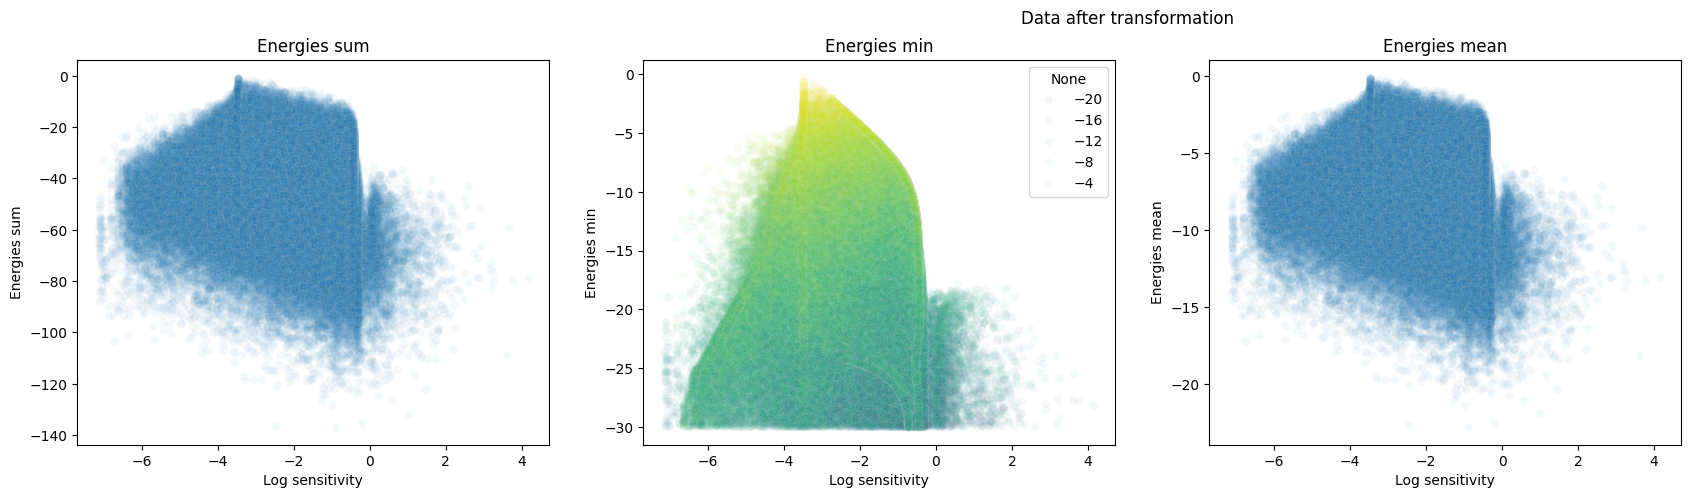

In [8]:
plt.figure(figsize=(4*7, 5))
ax = plt.subplot(1,4,1)
sns.scatterplot(x=df[OBJECTIVE_COL], y=df[X_COLS].sum(axis=1), alpha=0.05)
if PREP_X_LOGSCALE:
    plt.xscale('log')
plt.ylabel('Energies sum')
plt.title('Energies sum')
ax = plt.subplot(1,4,2)
sns.scatterplot(x=df[OBJECTIVE_COL], y=df[X_COLS].min(axis=1), alpha=0.05,
                hue=df[X_COLS].mean(axis=1), palette='viridis')
if PREP_X_LOGSCALE:
    plt.xscale('log')
plt.ylabel('Energies min')
plt.title('Energies min')
ax = plt.subplot(1,4,3)
sns.scatterplot(x=df[OBJECTIVE_COL], y=df[X_COLS].mean(axis=1), alpha=0.05)
if PREP_X_LOGSCALE:
    plt.xscale('log')
plt.ylabel('Energies mean')
plt.title('Energies mean')

plt.suptitle('Data after transformation')

### Reduce circuits that are overrepresented

In [9]:
# df = df.reset_index(drop=True)

# n_same_circ_max = 100
# nbin = 300
# agg_func = lambda x: tuple(x)

# df.loc[:, X_COLS] = df[X_COLS].apply(lambda x: np.round(x, 1))
# df_bal = balance_dataset(PRNG, df, cols=X_COLS, nbin=nbin, 
#                          bin_max=n_same_circ_max, use_log=False, func1=agg_func)
# # df_bal = df
# df_bal = df_bal.reset_index(drop=True)
# df = df_bal


Text(0.5, 1.0, 'Sensitivity after balancing')

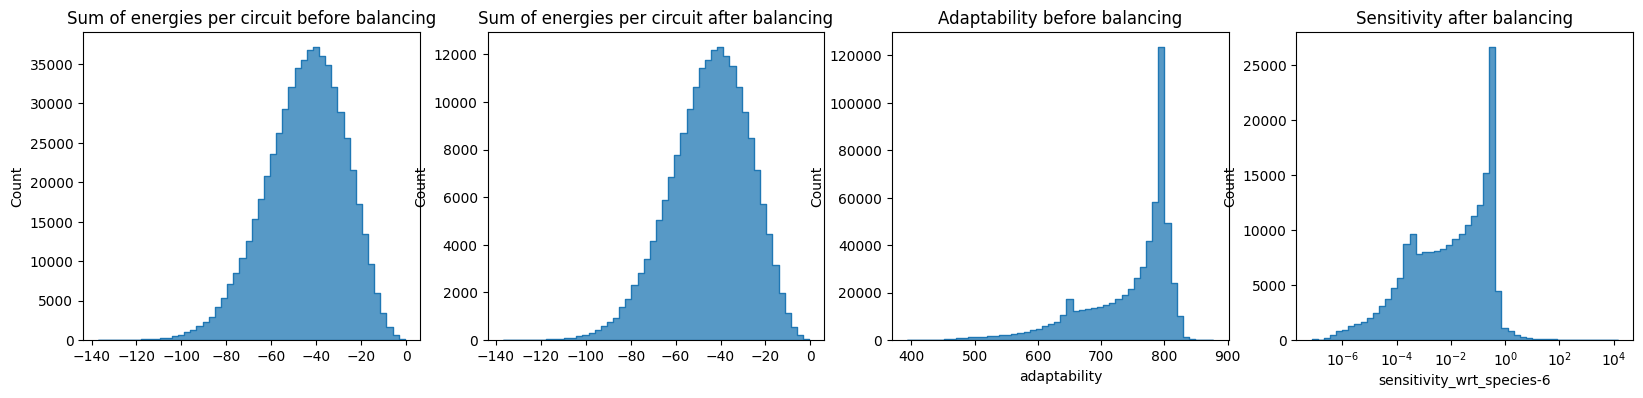

In [10]:
fig = plt.figure(figsize=(5*4, 4))
ax = plt.subplot(1,4,1)
sns.histplot(data[X_COLS].sum(axis=1), bins=50, log_scale=[False, False], element='step')
plt.title('Sum of energies per circuit before balancing')
# ylim = ax.get_ylim()
ax = plt.subplot(1,4,2)
sns.histplot(df[X_COLS].sum(axis=1), bins=50, log_scale=[False, False], element='step')
plt.title('Sum of energies per circuit after balancing')
# plt.ylim(ylim)
ax = plt.subplot(1,4,3)
sns.histplot(data, x='adaptability', bins=50, log_scale=[False, False], element='step')
plt.title('Adaptability before balancing')
ax = plt.subplot(1,4,4)
sns.histplot(df, x='sensitivity_wrt_species-6', bins=50, log_scale=[True, False], element='step')
plt.title('Sensitivity after balancing')


Text(0.5, 0.98, 'Energies of species in a peak adaptability range')

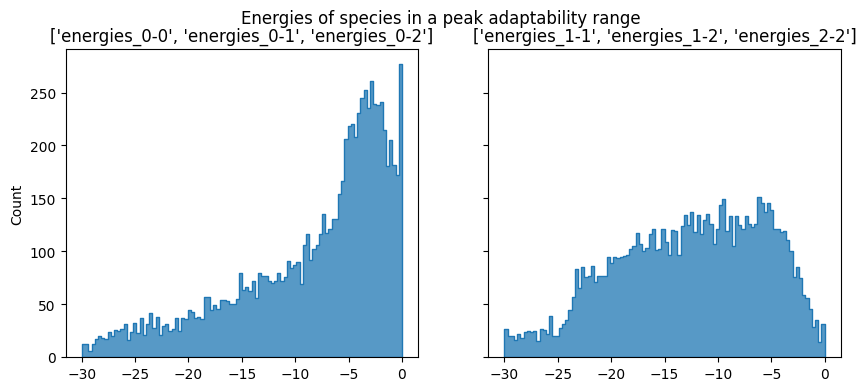

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

sns.histplot(df[df['adaptability'].between(650, 660)][X_COLS[:3]].min(axis=1), bins=100, element='step',
             ax=axs[0], log_scale=[False, False])
axs[0].set_title(X_COLS[:3])
sns.histplot(df[df['adaptability'].between(650, 660)][X_COLS[3:]].min(axis=1), bins=100, element='step',
             ax=axs[1], log_scale=[False, False])
axs[1].set_title(X_COLS[3:])
plt.suptitle('Energies of species in a peak adaptability range')

### Reduce the number of null circuits

In [12]:
# n_null_max = 100
# idxs_null = df[df[X_COLS].sum(axis=1) == 0].index

# df_bal2 = rem_idxs(df, np.random.choice(idxs_null, len(idxs_null) - n_null_max, replace=False))


# fig = plt.figure(figsize=(10,5))
# ax = plt.subplot(1,2,1)
# sns.histplot(df[X_COLS].sum(axis=1), bins=50, element='step')
# plt.title('Before')
# plt.xlabel('Sum of interactions')
# ax = plt.subplot(1,2,2)
# plt.title('After')
# plt.xlabel('Sum of interactions')
# sns.histplot(df_bal2[X_COLS].sum(axis=1), bins=50, element='step')
# plt.suptitle('Balancing null circuits')


In [13]:
# bin_max = int(np.power(10, 3))
# nbin = 50
# func1 = lambda x: np.sum(x, axis=1)
# # df_bal = balance_dataset2d(df_bal, cols1=X_COLS, cols2=OBJECTIVE_COL, nbins=nbin, bin_max=bin_max, use_log=False, func1=func1, func2=None)

# fig = plt.figure(figsize=(10,4))
# ax = plt.subplot(1,2,1)
# sns.histplot(x=df_bal[OBJECTIVE_COL].T, y=func1(df_bal[X_COLS].values).T, bins=nbin, cbar=True)
# plt.title('Before')

# # Need to recurse this subsampling to make it neat
# for i in range(20):
#     df_bal = balance_dataset2d(df_bal, cols1=X_COLS, cols2=OBJECTIVE_COL, nbins=nbin, bin_max=bin_max, use_log=False, func1=func1, func2=None)

# ax = plt.subplot(1,2,2)
# plt.title('After')
# sns.histplot(x=df_bal[OBJECTIVE_COL].T, y=func1(df_bal[X_COLS].values).T, bins=nbin, cbar=True)
# plt.suptitle('Balancing energies + adaptability')

Text(0.5, 0.98, 'Balance of dataset for conditioning variable Log sensitivity')

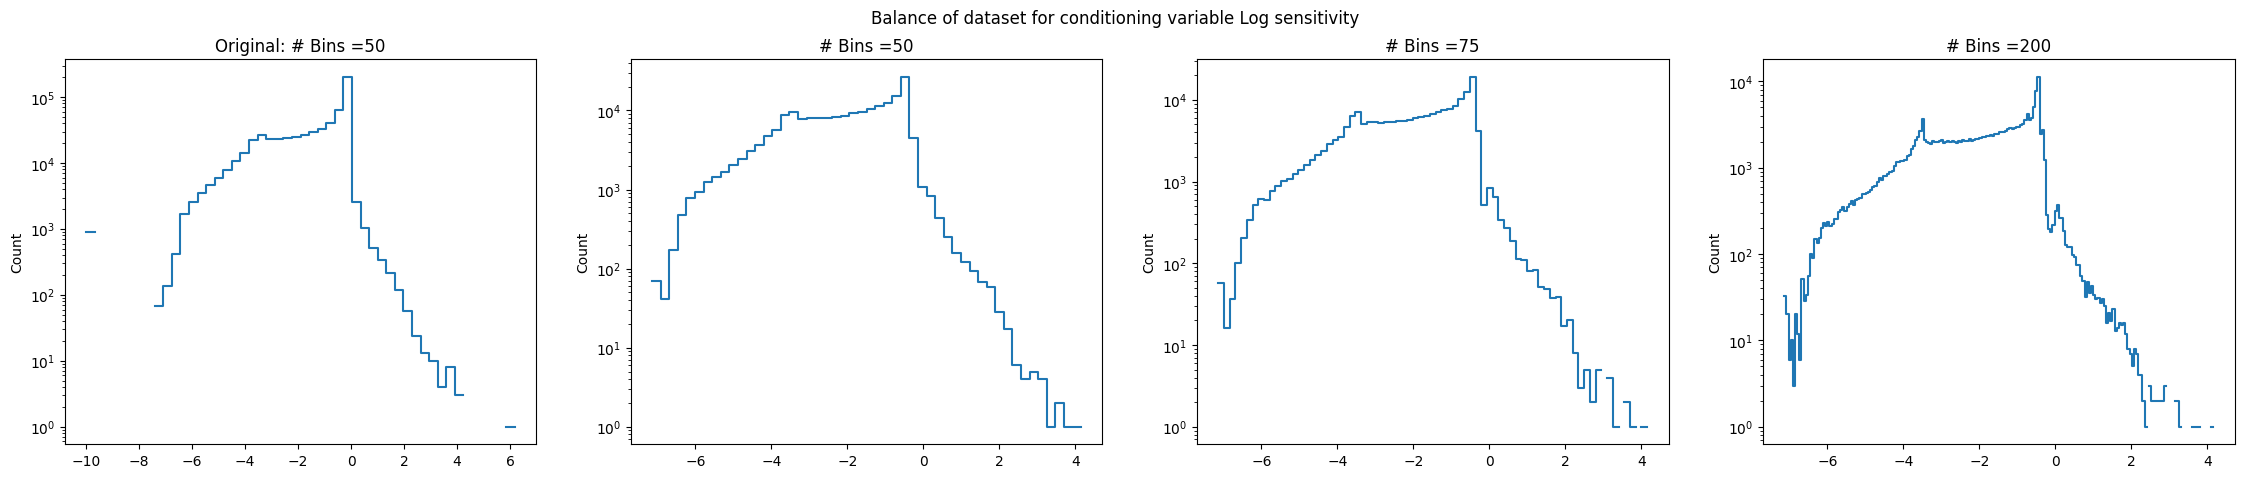

In [14]:
# Balance by bins
nbin = 50
bin_max = int(np.power(10, 4))
# df = balance_dataset(df, cols=OBJECTIVE_COL, nbin=nbin, bin_max=bin_max, use_log=False)
# df = balance_dataset(data, cols=X_COLS, nbin=300, bin_max=bin_max, use_log=False, func1=lambda x: np.sum(x, axis=1))

fig = plt.figure(figsize=(4*7, 5))
ax = plt.subplot(1,4,1)
sns.histplot(data[OBJECTIVE_COL].to_numpy().flatten(), bins=50, log_scale=[False, True], element='step', fill=False)
plt.title('Original: # Bins =' + str(50))
ax = plt.subplot(1,4,2)
sns.histplot(df[OBJECTIVE_COL].to_numpy().flatten(), bins=nbin, log_scale=[False, True], element='step', fill=False)
plt.title('# Bins =' + str(nbin))
ax = plt.subplot(1,4,3)
sns.histplot(df[OBJECTIVE_COL].to_numpy().flatten(), bins=int(nbin*1.5), log_scale=[False, True], element='step', fill=False)
plt.title('# Bins =' + str(int(nbin*1.5)))
ax = plt.subplot(1,4,4)
sns.histplot(df[OBJECTIVE_COL].to_numpy().flatten(), bins=nbin*4, log_scale=[False, True], element='step', fill=False)
plt.title('# Bins =' + str(nbin*4))

plt.suptitle('Balance of dataset for conditioning variable ' + str(OBJECTIVE_COL))


In [15]:
# if TOTAL_DS is None:
#     TOTAL_DS = len(df)
# TOTAL_DS = int(np.min([TOTAL_DS, TOTAL_DS_MAX, len(df)]))
# TOTAL_DS = int(TOTAL_DS // BATCH_SIZE * BATCH_SIZE)
# N_BATCHES = int(TOTAL_DS // BATCH_SIZE)

### Scale the input data

In [16]:
x_norm_settings = NormalizationSettings(
    negative=PREP_X_NEG,
    logscale=PREP_X_LOGSCALE,
    standardise=PREP_X_STANDARDISE,
    min_max=PREP_X_MINMAX,
    robust_scaling=PREP_X_ROBUST_SCALING,
    categorical=PREP_X_CATEGORICAL,
    categorical_onehot=PREP_X_CATEGORICAL_ONEHOT,
    categorical_n_bins=PREP_X_CATEGORICAL_NBINS,
    categorical_method=PREP_X_CATEGORICAL_METHOD
)
y_norm_settings = NormalizationSettings(
    negative=PREP_Y_NEG,
    logscale=PREP_Y_LOGSCALE,
    standardise=PREP_Y_STANDARDISE,
    min_max=PREP_Y_MINMAX,
    robust_scaling=PREP_Y_ROBUST_SCALING,
    categorical=PREP_Y_CATEGORICAL,
    categorical_onehot=PREP_Y_CATEGORICAL_ONEHOT,
    categorical_n_bins=PREP_Y_CATEGORICAL_NBINS,
    categorical_method=PREP_Y_CATEGORICAL_METHOD
)

TOTAL_DS = int(np.min([TOTAL_DS_MAX, len(df)]))
if TOTAL_DS < BATCH_SIZE:
    print(f'TOTAL_DS is less than BATCH_SIZE: {TOTAL_DS} < {BATCH_SIZE}')
    BATCH_SIZE = TOTAL_DS
else:
    TOTAL_DS = int(TOTAL_DS // BATCH_SIZE * BATCH_SIZE)
if TOTAL_DS == 0:
    raise ValueError('TOTAL_DS is 0')
N_BATCHES = int(TOTAL_DS // BATCH_SIZE)

x, cond, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing = make_xy(df, PRNG, TOTAL_DS, X_COLS, OBJECTIVE_COL,
                                                                                                        x_norm_settings, y_norm_settings)

In [17]:
cond.shape, x.shape, np.concatenate([x, cond], axis=-1).shape

((198016, 10), (198016, 6), (198016, 16))

Text(0.5, 0.98, 'Dataset after balancing')

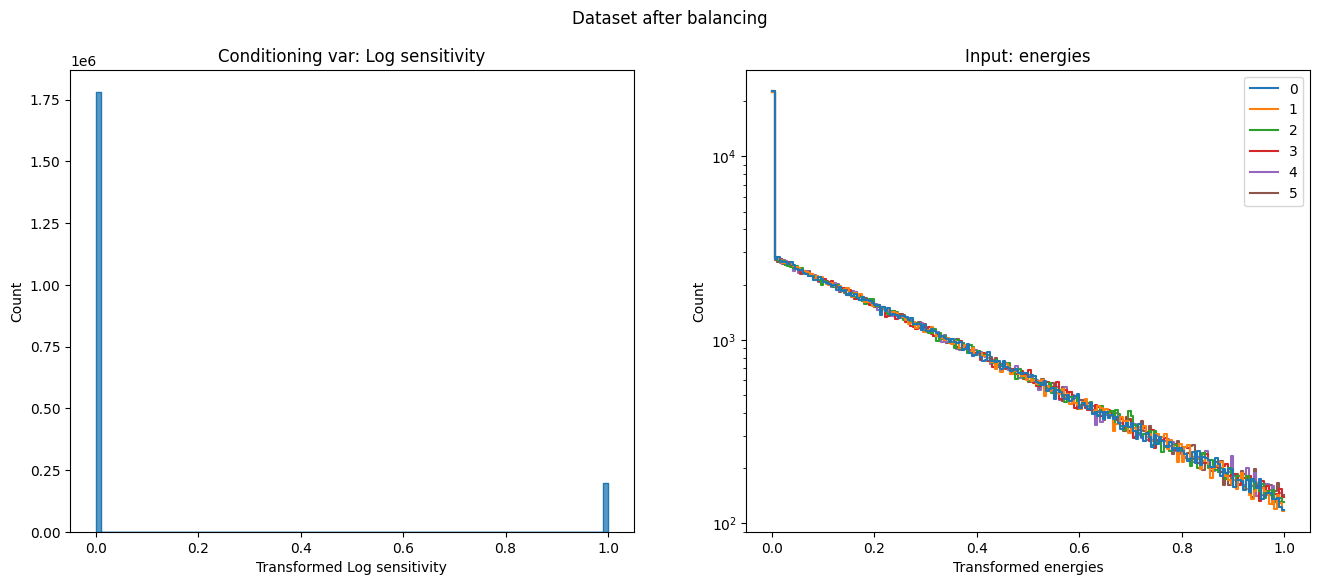

In [18]:
fig = plt.figure(figsize=(2*8, 6))

ax = plt.subplot(1,2,1)
sns.histplot(cond.flatten(), log_scale=[False, False], bins=100, element='step', fill=True)
plt.title(f'Conditioning var: {OBJECTIVE_COL}')
plt.xlabel(f'Transformed {OBJECTIVE_COL}')

ax = plt.subplot(1,2,2)
sns.histplot(x, element='step', fill=False, bins=200, log_scale=[False, True])
plt.title(f'Input: {X_TYPE}')
plt.xlabel(f'Transformed {X_TYPE}')

plt.suptitle('Dataset after balancing')

## Init model

In [19]:
model_fn = partial(VAE_fn, enc_layers=enc_layers, dec_layers=dec_layers, decoder_head=x.shape[-1], 
                  #  HIDDEN_SIZE=HIDDEN_SIZE, USE_SIGMOID_DECODER=USE_SIGMOID_DECODER, enc_init='RandomNormal', dec_init='RandomNormal')
                   HIDDEN_SIZE=HIDDEN_SIZE, decoder_activation_final=jax.nn.sigmoid if USE_SIGMOID_DECODER else jax.nn.leaky_relu, 
                   enc_init=ENC_INIT, dec_init=DEC_INIT, activation=get_activation_fn(ACTIVATION), dropout_rate=DROPOUT_RATE if USE_DROPOUT else None)
# model = hk.transform(model_fn)
model_t = hk.multi_transform(model_fn)
dummy_x = jax.random.normal(PRNG, x.shape)
dummy_cond = jax.random.normal(PRNG, cond.shape)
params = model_t.init(PRNG, dummy_x, dummy_cond, deterministic=False)


In [20]:
encoder, decoder, model, h2mu, h2logvar, reparam = model_t.apply


In [21]:
h = encoder(params, PRNG, np.concatenate([x, cond], axis=-1))

In [22]:
model(params, PRNG, x, cond, return_muvar=False).shape

(198016, 6)

Text(0.5, 0.98, 'Weight init with dummy xy using HeNormal and activation leaky_relu')

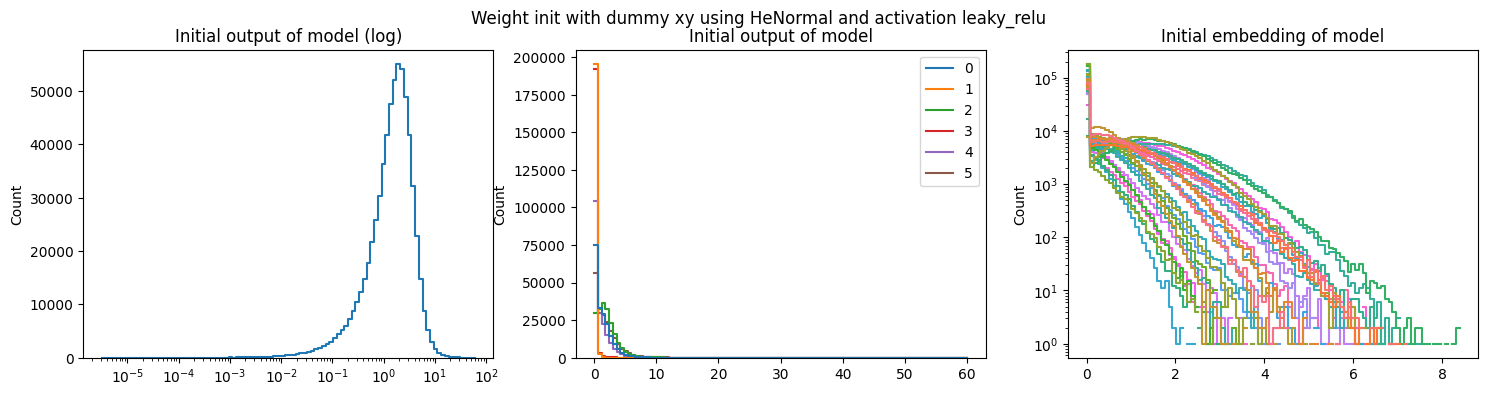

In [23]:
fig = plt.figure(figsize=(3*6, 4))
plt.subplot(1,3,1)
sns.histplot(model(params, PRNG, dummy_x, dummy_cond).flatten(), bins=100, log_scale=[True, False], element='step', fill=False)
plt.title('Initial output of model (log)')
plt.subplot(1,3,2)
sns.histplot(model(params, PRNG, dummy_x, dummy_cond), bins=100, log_scale=[False, False], element='step', fill=False)
# sns.histplot(model(params, PRNG, x, cond), bins=100, log_scale=[True, False], element='step', fill=False)
plt.title('Initial output of model')
plt.subplot(1,3,3)
sns.histplot(encoder(params, PRNG, np.concatenate([dummy_x, dummy_cond], axis=-1)), bins=100, log_scale=[False, True], element='step', fill=False, legend=False)
plt.title('Initial embedding of model')
plt.suptitle(f'Weight init with dummy xy using {DEC_INIT} and activation {ACTIVATION}')

Text(0.5, 0.98, 'Weight init with actual xy using HeNormal and activation leaky_relu')

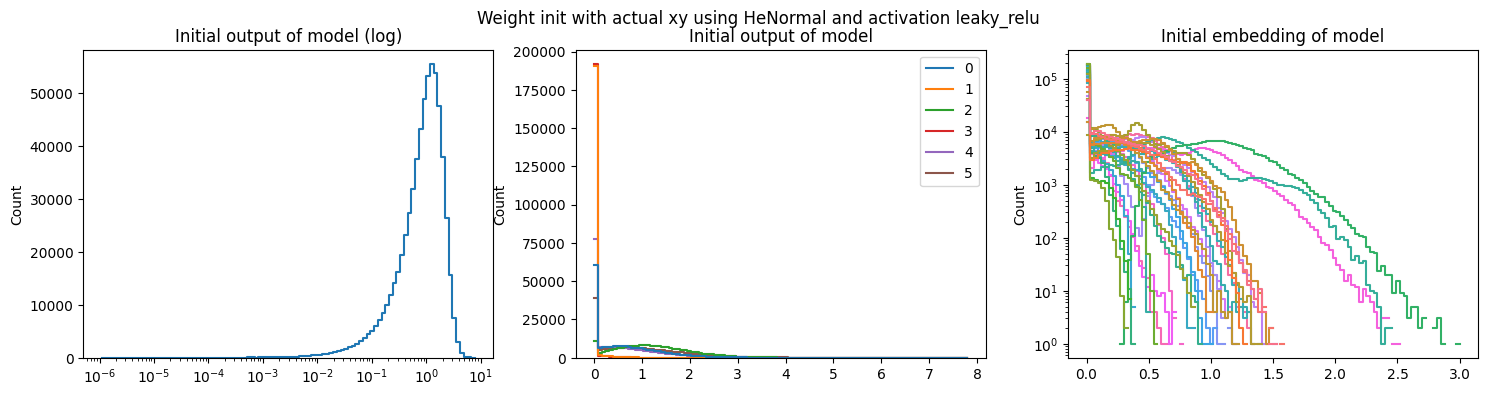

In [24]:
fig = plt.figure(figsize=(3*6, 4))
plt.subplot(1,3,1)
sns.histplot(model(params, PRNG, x, cond).flatten(), bins=100, log_scale=[True, False], element='step', fill=False)
plt.title('Initial output of model (log)')
plt.subplot(1,3,2)
sns.histplot(model(params, PRNG, x, cond), bins=100, log_scale=[False, False], element='step', fill=False)
# sns.histplot(model(params, PRNG, x, cond), bins=100, log_scale=[True, False], element='step', fill=False)
plt.title('Initial output of model')
plt.subplot(1,3,3)
sns.histplot(encoder(params, PRNG, np.concatenate([x, cond], axis=-1)), bins=100, log_scale=[False, True], element='step', fill=False, legend=False)
plt.title('Initial embedding of model')
plt.suptitle(f'Weight init with actual xy using {DEC_INIT} and activation {ACTIVATION}')

In [25]:
# Potential diagnostic code
def print_layer_stats(model):
    for name, module in model.items():
        if 'w' in module:
            print(f"Layer {name}:")
            print(f"  Weight mean: {module['w'].mean().item()}")
            print(f"  Weight std: {module['w'].std().item()}")

print_layer_stats(params)

Layer encoder/~create_layers/linear_0:
  Weight mean: 0.01085933018475771
  Weight std: 0.3518253564834595
Layer encoder/~create_layers/linear_1:
  Weight mean: -0.000737650552764535
  Weight std: 0.17675001919269562
Layer encoder/~create_layers/linear_2:
  Weight mean: 0.004321327432990074
  Weight std: 0.17463542520999908
Layer cvae/~/h2mu:
  Weight mean: -0.0021995988208800554
  Weight std: 0.15197835862636566
Layer cvae/~/h2logvar:
  Weight mean: 0.003116301726549864
  Weight std: 0.1506325602531433
Layer decoder/~create_layers/linear_0:
  Weight mean: 0.003633158979937434
  Weight std: 0.21151480078697205
Layer decoder/~create_layers/linear_1:
  Weight mean: -0.008446767926216125
  Weight std: 0.24888162314891815
Layer decoder/~create_layers/linear_2:
  Weight mean: 0.002495227847248316
  Weight std: 0.1798621118068695
Layer decoder/~create_layers/linear_3:
  Weight mean: -0.0012780803954228759
  Weight std: 0.1826973706483841


## Init optimiser

In [26]:
optimiser = make_optimiser(LEARNING_RATE_SCHED, LEARNING_RATE,
                           EPOCHS, L2_REG_ALPHA, USE_WARMUP, WARMUP_EPOCHS, N_BATCHES)
optimiser_state = optimiser.init(x)

# Train

In [27]:
x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val = make_training_data(
    x, cond, TRAIN_SPLIT, N_BATCHES, BATCH_SIZE)

In [28]:
np.prod(x_train.shape[:2]), np.prod(x_val.shape[:2])


(np.int64(158336), np.int64(39680))

Text(0.5, 1.0, 'Preprocessing of conditional data')

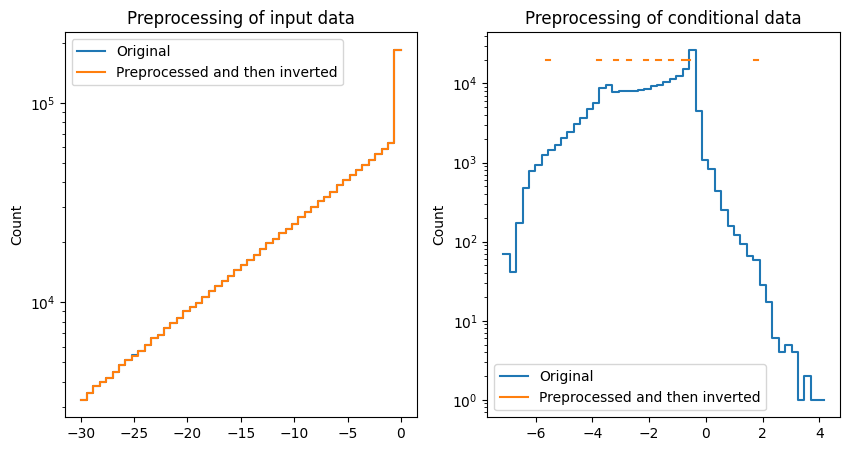

In [30]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
sns.histplot(np.concatenate([df[i].iloc[:TOTAL_DS].values[:, None] for i in X_COLS], axis=1).squeeze().flatten(), bins=50, log_scale=[False, True], element='step', fill=False, label='Original')
sns.histplot(x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(x).flatten(), bins=50, log_scale=[False, True], element='step', fill=False, label='Preprocessed and then inverted')
plt.legend()
plt.title('Preprocessing of input data')

plt.subplot(1,2,2)
sns.histplot(df[OBJECTIVE_COL].iloc[:TOTAL_DS].values.flatten(), bins=50, log_scale=[False, True], element='step', fill=False, label='Original')
sns.histplot(y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(cond).flatten(), bins=50, log_scale=[False, True], element='step', fill=False, label='Preprocessed and then inverted')
plt.legend()
plt.title('Preprocessing of conditional data')


## Run train

In [ ]:
tstart = datetime.now()
params, saves = train(params, PRNG, model,
                      x_train, cond_train, y_train, x_val, cond_val, y_val, 
                      optimiser, optimiser_state,
                      use_l2_reg=USE_L2_REG, l2_reg_alpha=L2_REG_ALPHA, epochs=EPOCHS,
                      loss_fn=loss_fn, compute_accuracy=accuracy_regression,
                      save_every=PRINT_EVERY, include_params_in_all_saves=False) 

print(datetime.now() - tstart)

# Visualise

Text(0.5, 0.98, 'Training')

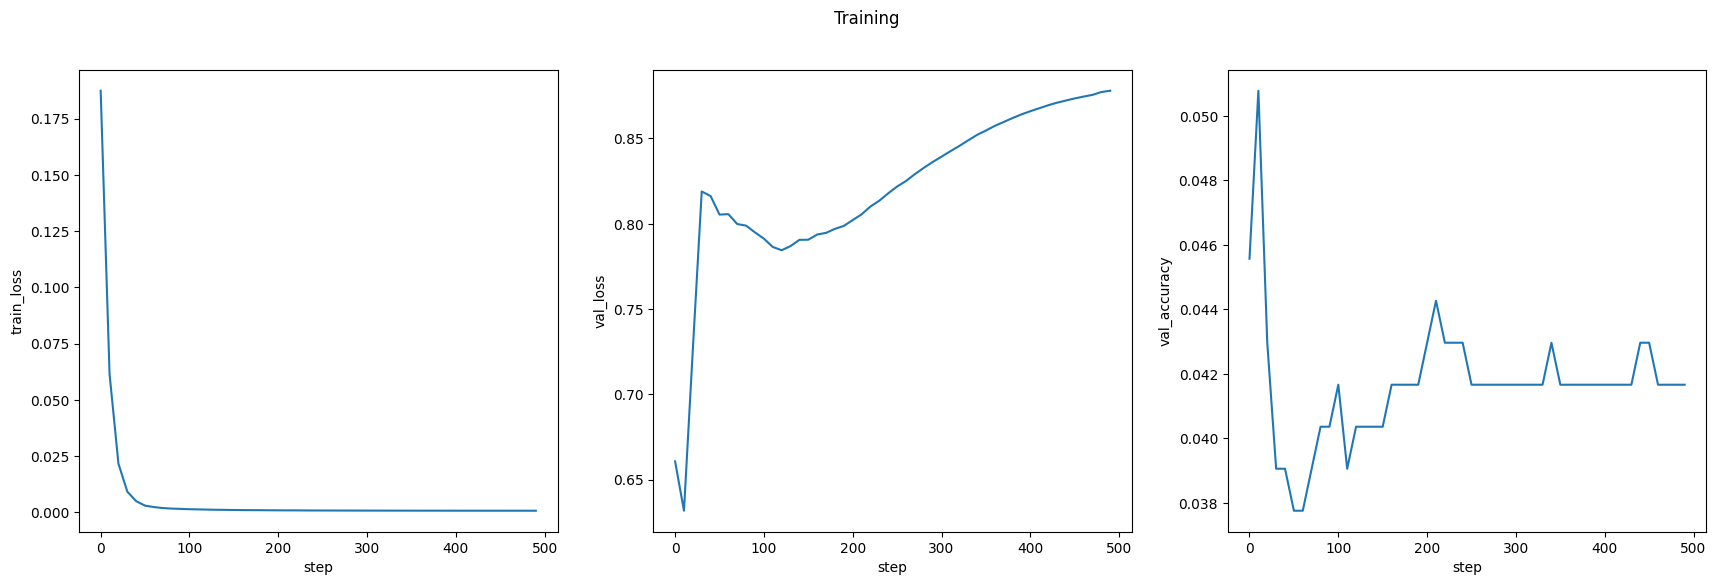

In [69]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1, 3, 1)
plt.plot(list(saves.keys()), [v['train_loss'] for v in saves.values()])
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(saves.keys()), [v['val_loss'] for v in saves.values()])
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(saves.keys()), [v['val_accuracy'] for v in saves.values()])
plt.ylabel('val_accuracy')
plt.xlabel('step')

plt.suptitle('Training')

In [ ]:
write_json(saves, out_path=save_path)

In [ ]:
print(save_path)

weight_saves/01_cvae/2024_12_17__12_24_18_saves_Eneg_onehot_ls2_hs32


# Examine trained model

In [31]:
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_27__15_01_35_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_27__16_58_36_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_28__14_12_59_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_29__10_43_59_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_02__13_49_00_saves_test')  # sensitivity
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_06__14_54_23_saves_test')  # generated from interactions
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_06__17_57_39_saves_test')  # generated from interactions with sigmoid in decoder for 500 epochs
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__17_45_52_saves_no_sigmoid_decoder')  # generated from interactions with sigmoid in decoder for 2000 epochs
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__18_59_40_saves_KL_div')  # generated from interactions + relu + sigmoid + KL divergence
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__20_55_42_saves_no_KL')  # generated from interactions + relu + sigmoid
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__21_21_04_saves_no_KL')  # generated from interactions + relu 
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__22_17_13_saves_leaky_relu')  # generated from interactions + leaky relu 
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__22_48_33_saves_KL_leakyrelu')  # generated from interactions + leaky relu + KL
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__23_01_53_saves_KL_leakyrelu')  # generated from interactions + leaky relu + KL + encoder head hidden size
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__14_24_25_saves_new_MLP')  # generated from interactions + new MLP
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__15_28_08_saves_layers_1')  # generated from interactions + only 1 layer for enc and dec
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__15_51_40_saves_he_init')  # generated from interactions + only 1 layer for enc and dec
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__16_13_34_saves_he_init_KL_ls1')  # generated from interactions + only 1 layer for enc and dec + KL
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__16_49_29_saves_robust_KL_e2000')  # generated from interactions + KL + robust scaling + 2000 epochs
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__22_09_41_saves_nosigmoid_KL_new_reparam')  # generated from interactions + KL + no sigmoid + new reparameterisation function + sensitivity ---> DID NOT WORK, NANS
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__23_27_37_saves_sens_brd_KL_weight')  # generated from interactions + KL + no sigmoid + new reparameterisation function + sensitivity ---> DID NOT WORK, NANS
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__13_36_05_saves_sens_brd_KL_weight')  # generated from interactions + no sigmoid + new reparameterisation function + sensitivity 500 epochs
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__14_31_37_saves_sens_en_lr1e3')  # generated from interactions + log sensitivity 3000 epochs + lr 1e-3
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__14_45_23_saves_sens_en_lr1e3')  # generated from interactions + log sensitivity 3000 epochs + lr 1e-3 + KL + 3 layers instead of 1
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__17_00_32_saves_onehot')  # generated from interactions + log sensitivity + energies + onehot
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__17_46_49_saves_onehot_lr1e1')  # generated from interactions + log sensitivity + energies + onehot + lr 1e-1
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__17_53_31_saves_onehot_nominmax')  # generated from interactions + log sensitivity + energies + onehot + lr 1e-1 + no minmax just robust scaling
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__18_20_05_saves_onehot_minmax_epochs10k')  # generated from interactions + log sensitivity + energies + onehot + lr 1e-1 + 10k epochs + minmax
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__21_59_51_saves_onehot_quantile')  # generated from interactions + log sensitivity + onehot + quantile categorical + lr 1e-1 + 10k epochs + minmax
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_11__11_39_29_saves_log_sens_sigmoid_nocat')  # generated from interactions + log sensitivity + no onehot + lr 5e-2 + 10k epochs + minmax + sigmoid
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_11__14_22_59_saves_winit_glorot')  # generated from interactions + log sensitivity + no onehot + lr 5e-2 + sigmoid + minmax + glorot init
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_11__15_17_29_saves_henorm_nosig_minmax')  # generated from interactions + log sensitivity + no onehot + lr 1e-1 + minmax + no sigmoid + he normal init
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_11__17_54_40_saves_henorm_nosig_minmax')  # generated from interactions + log sensitivity + no onehot + lr 1e-1 + minmax + no sigmoid + he normal init
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_12__16_17_49_saves_Eneg_henorm_nosigm_nocat')  # generated from interactions + log sensitivity + no onehot + lr 1e-1 + minmax + no sigmoid + he normal init
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_13__10_59_59_saves_Eneg_onehot')  # generated from interactions + log sensitivity + onehot + lr5e-2 + minmax + no sigmoid + he normal init
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_15__18_08_07_saves_Eneg_onehot_ls3')  # generated from interactions + log sensitivity + onehot + lr5e-2 + minmax + no sigmoid + he normal init + 3 layers + hidden size 64
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_15__18_36_21_saves_Eneg_onehot_ls3_hs32')  # generated from interactions + log sensitivity + onehot + lr5e-2 + minmax + no sigmoid + he normal init + 3 layers + hidden size 32
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_17__13_19_13_saves_Eneg_onehot_ls2_hs32')  # generated from interactions + log sensitivity + onehot + lr5e-2 + minmax + no sigmoid + he normal init + 2 layers + hidden size 32
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_17__15_38_11_saves_KLw25e2')  # generated from interactions + log sensitivity + energies negative onehot + lr1e-1 + minmax + no sigmoid + he normal init + 2 layers + hidden size 32 + KL weight 2.5e-2
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_17__16_22_43_saves_KLw25e3')  # generated from interactions + log sensitivity + energies negative onehot + lr5e-2 + minmax + no sigmoid + he normal init + 2 layers + hidden size 32 + KL weight 2.5e-3
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_17__18_48_25_saves_KLw1e3_lr1e1')  # generated from interactions + log sensitivity + energies negative onehot + lr1e-1 + minmax + no sigmoid + he normal init + 2 layers + hidden size 32 + KL weight 1e-3
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_17__19_05_55_saves_KLw5e4_L21e1')  # generated from interactions + log sensitivity + energies negative onehot + lr1e-1 + minmax + no sigmoid + he normal init + 2 layers + hidden size 32 + KL weight 5e-4 + L2 reg
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_18__12_19_07_saves_bug_fix')  # generated from interactions + log sensitivity + energies negative onehot + lr1e-1 + minmax + no sigmoid + he normal init + 2 layers + hidden size 32 + KL weight 2.5e-4
saves_loaded = load_json_as_dict(fn_saves)

p = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
p = arrayise(p)
# p['vae/~/h2mu'] = p.pop('vae/~/linear')
# p['vae/~/h2logvar'] = p.pop('vae/~/linear_1')

pred_y = model(p, PRNG, x, cond)
pred_y.shape

(1547, 128, 6)

Text(0.5, 0.98, 'Training')

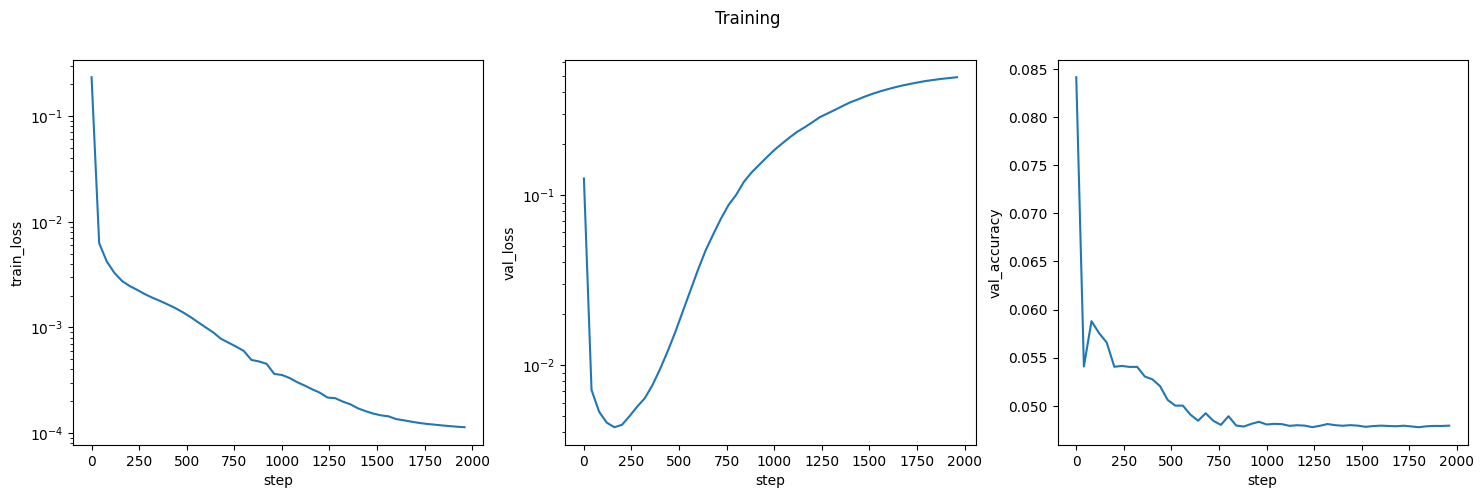

In [32]:
plt.figure(figsize=(6*3, 5))
ax = plt.subplot(1, 3, 1)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['train_loss']) for v in saves_loaded.values()]))
plt.yscale('log')
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['val_loss']) for v in saves_loaded.values()]))
plt.yscale('log')
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['val_accuracy']) for v in saves_loaded.values()]))
plt.ylabel('val_accuracy')
plt.xlabel('step')
plt.suptitle('Training')

The R2 score is  -7.752194404602051
The R2 score with weighted variance is  -7.752194404602051


/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


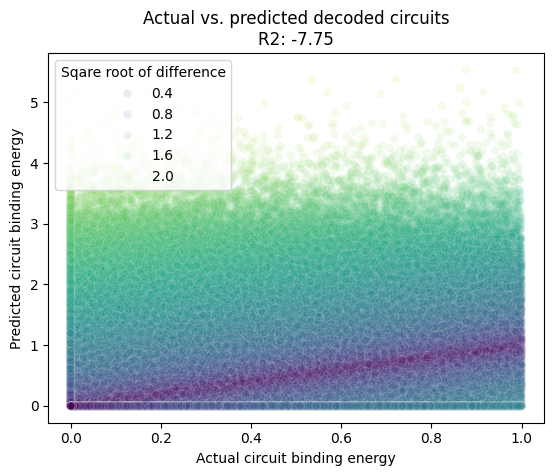

In [33]:
g = sns.scatterplot(x=y.flatten(), y=pred_y.flatten(), alpha=0.1, hue=np.sqrt(np.abs(pred_y.flatten() - y.flatten())), palette='viridis')
g.legend_.set_title('Sqare root of difference')
plt.title(f'Actual vs. predicted decoded circuits\nR2: {r2_score(y.flatten(), pred_y.flatten()):.2f}')
plt.xlabel('Actual circuit binding energy')
plt.ylabel('Predicted circuit binding energy')

print('The R2 score is ', r2_score(y.flatten(), pred_y.flatten()))
print('The R2 score with weighted variance is ', r2_score(
    y.flatten(), pred_y.flatten(), multioutput='variance_weighted'))

# Sample fake circuits

In [ ]:
n_to_sample = 10000

sampled_cond = np.interp(jax.random.normal(PRNG, (n_to_sample, cond.shape[-1])), [0, 1], [cond.min(), cond.max()])
sampled_h = np.random.rand(n_to_sample, ENC_LS)
# mu = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 10
# logvar = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 0.5
# mu = h2mu(p, PRNG, sampled_h) 
# logvar = h2logvar(p, PRNG, sampled_h)
# z = sample_z(mu=mu, logvar=logvar, key=PRNG)
z = jax.random.normal(PRNG, (n_to_sample, HIDDEN_SIZE))
z = np.concatenate([z, sampled_cond], axis=-1)

fake_circuits = decoder(p, PRNG, z)
# fake_circuits = np.where(fake_circuits > 0, 0, fake_circuits)
sampled_cond.shape

(10000, 10)

Text(0.5, 1.0, 'Generated fake circuits')

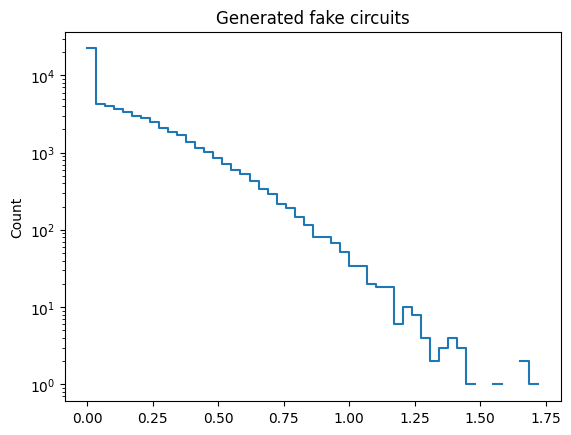

In [ ]:
sns.histplot(fake_circuits.flatten(), bins=50, log_scale=[False, True], element='step', fill=False)
plt.title('Generated fake circuits')

Text(0.5, 0.98, 'Interactions for CVAE: 10000 circuits')

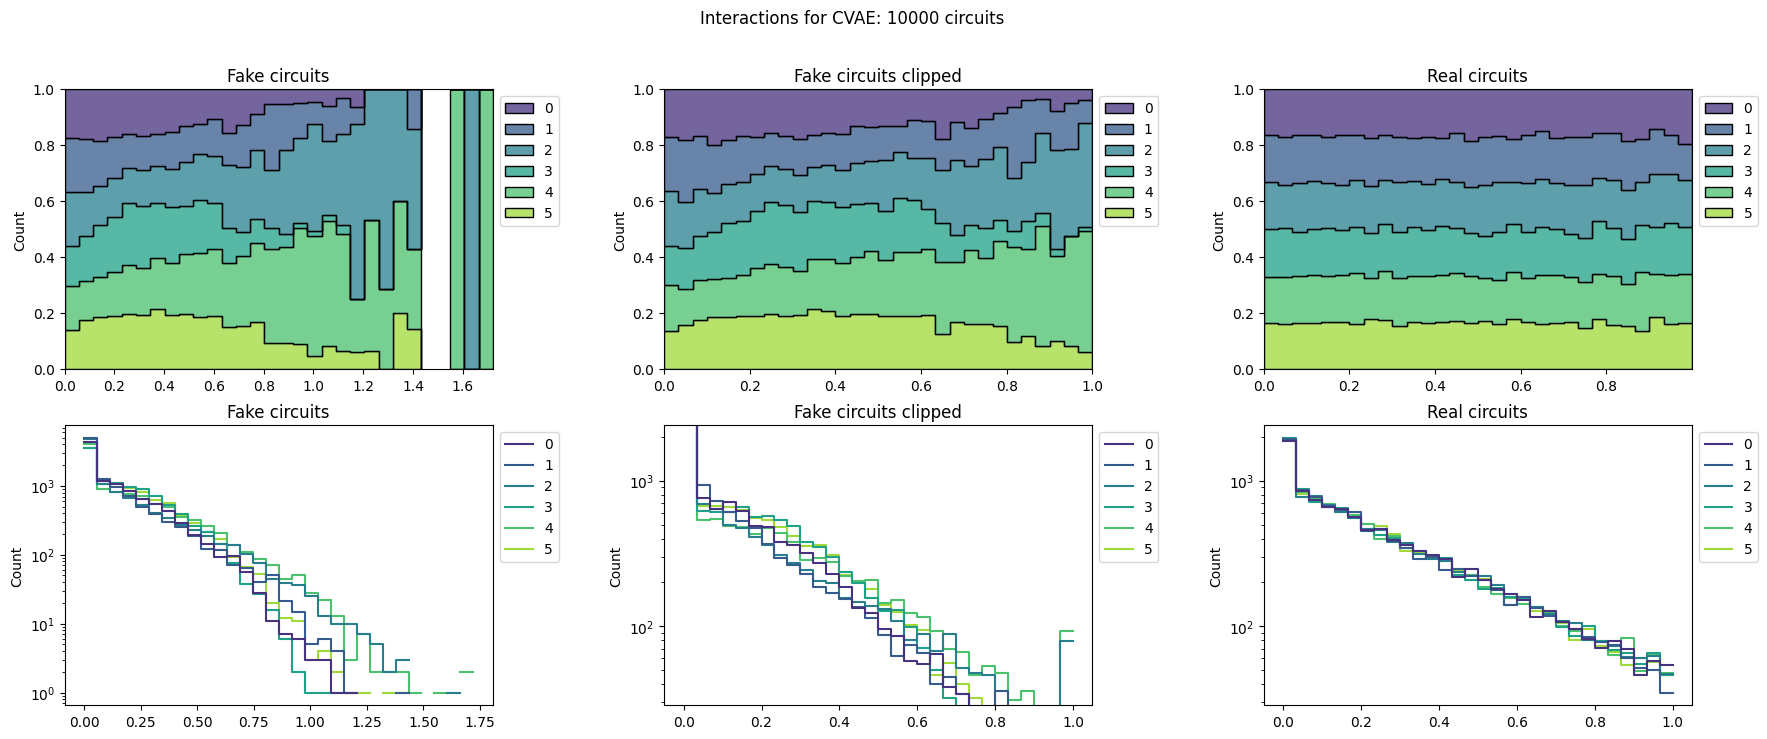

In [ ]:
fig = plt.figure(figsize=(7*3, 8))
fig.subplots_adjust(wspace=0.4)

ax = plt.subplot(2, 3, 1)
g = sns.histplot(fake_circuits, element='step', bins=30,
                 palette='viridis', multiple='fill')
plt.title('Fake circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 2)
g = sns.histplot(np.where(fake_circuits > x.max(), x.max(), np.where(fake_circuits < x.min(), x.min(), fake_circuits)), 
                 element='step', bins=30,
                 palette='viridis', multiple='fill')
plt.title('Fake circuits clipped')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 3)
g = sns.histplot(x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:n_to_sample],
                 element='step', bins=30, palette='viridis', multiple='fill')
plt.title('Real circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 4)
g = sns.histplot(fake_circuits, element='step', bins=30, palette='viridis',
                 multiple='layer', fill=False, log_scale=[False, True])
plt.title('Fake circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 5)
g = sns.histplot(np.where(fake_circuits > x.max(), x.max(), np.where(fake_circuits < x.min(), x.min(), fake_circuits)), 
                 element='step', bins=30, palette='viridis',
                 multiple='layer', fill=False, log_scale=[False, True])
plt.title('Fake circuits clipped')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 6)
x_hist = x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:n_to_sample]
g2 = sns.histplot(x_hist, element='step', bins=30, palette='viridis',
                  multiple='layer', fill=False, log_scale=[False, True])
plt.title('Real circuits')
sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))

g.set_ylim(g2.get_ylim())

plt.suptitle(f'Interactions for CVAE: {n_to_sample} circuits')

Text(0.5, 0.98, 'CVAE: 2000 circuits')

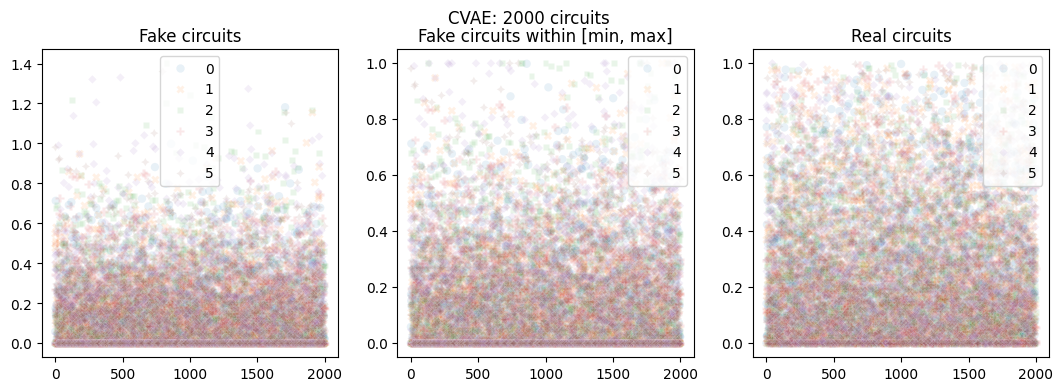

In [ ]:
fig = plt.figure(figsize=(13, 4))

show_max = 2000

ax = plt.subplot(1, 3, 1)
sns.scatterplot(fake_circuits[:show_max], alpha=0.1)
plt.title('Fake circuits')

ax = plt.subplot(1, 3, 2)
fake_circuits_1 = np.where(fake_circuits[:show_max] > x.max(), x.max(), fake_circuits[:show_max])
sns.scatterplot(np.where(fake_circuits_1 < x.min(), x.min(), fake_circuits_1), alpha=0.1)
plt.title('Fake circuits within [min, max]')

ax = plt.subplot(1, 3, 3)
sns.scatterplot(
    x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:show_max], alpha=0.1)
plt.title('Real circuits')

plt.suptitle(f'CVAE: {show_max} circuits')

## Conditionality

In [ ]:
n_categories = 5 if not PREP_Y_CATEGORICAL_ONEHOT else PREP_Y_CATEGORICAL_NBINS
n_to_sample = 10000

if PREP_Y_CATEGORICAL_ONEHOT:
    sampled_cond = np.repeat(np.arange(PREP_Y_CATEGORICAL_NBINS)[:, None], repeats=n_to_sample, axis=1)
    sampled_cond = jax.nn.one_hot(sampled_cond, PREP_Y_CATEGORICAL_NBINS)
else:
    sampled_cond = np.repeat(np.linspace(cond.min(), cond.max(), n_categories)[:, None], repeats=n_to_sample, axis=1)[:, :, None]
# mu = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 1
# logvar = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 2
# z = sample_z(mu=mu, logvar=logvar, key=PRNG)
z = jax.random.normal(PRNG, (n_to_sample, HIDDEN_SIZE))
z = np.repeat(z[None, :], repeats=n_categories, axis=0)
z = np.concatenate([z, sampled_cond], axis=-1)

fake_circuits = jax.vmap(partial(decoder, params=p, rng=PRNG))(inputs=z)
# fake_circuits = np.where(fake_circuits > 0, 0, fake_circuits)

fake_circuits.shape, sampled_cond.shape

((10, 10000, 6), (10, 10000, 10))

Text(0.5, 1.0, 'Fake circuits params')

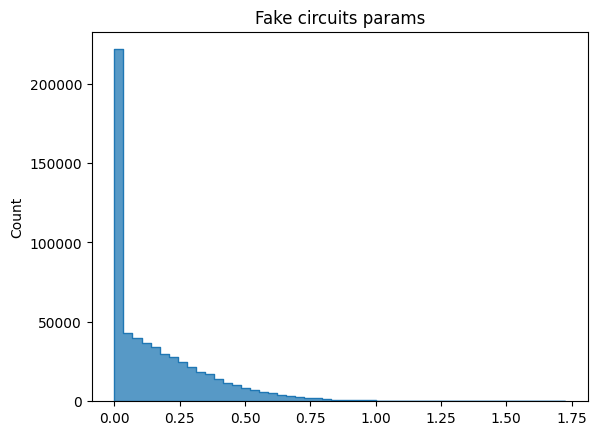

In [ ]:
# sns.histplot(decoder(p, PRNG, z).flatten(), bins=50)
sns.histplot(fake_circuits.flatten(), bins=50, element='step')
plt.title('Fake circuits params')

In [ ]:
len(z)

10

Text(0.5, 0.98, 'CVAE: fake circuits')

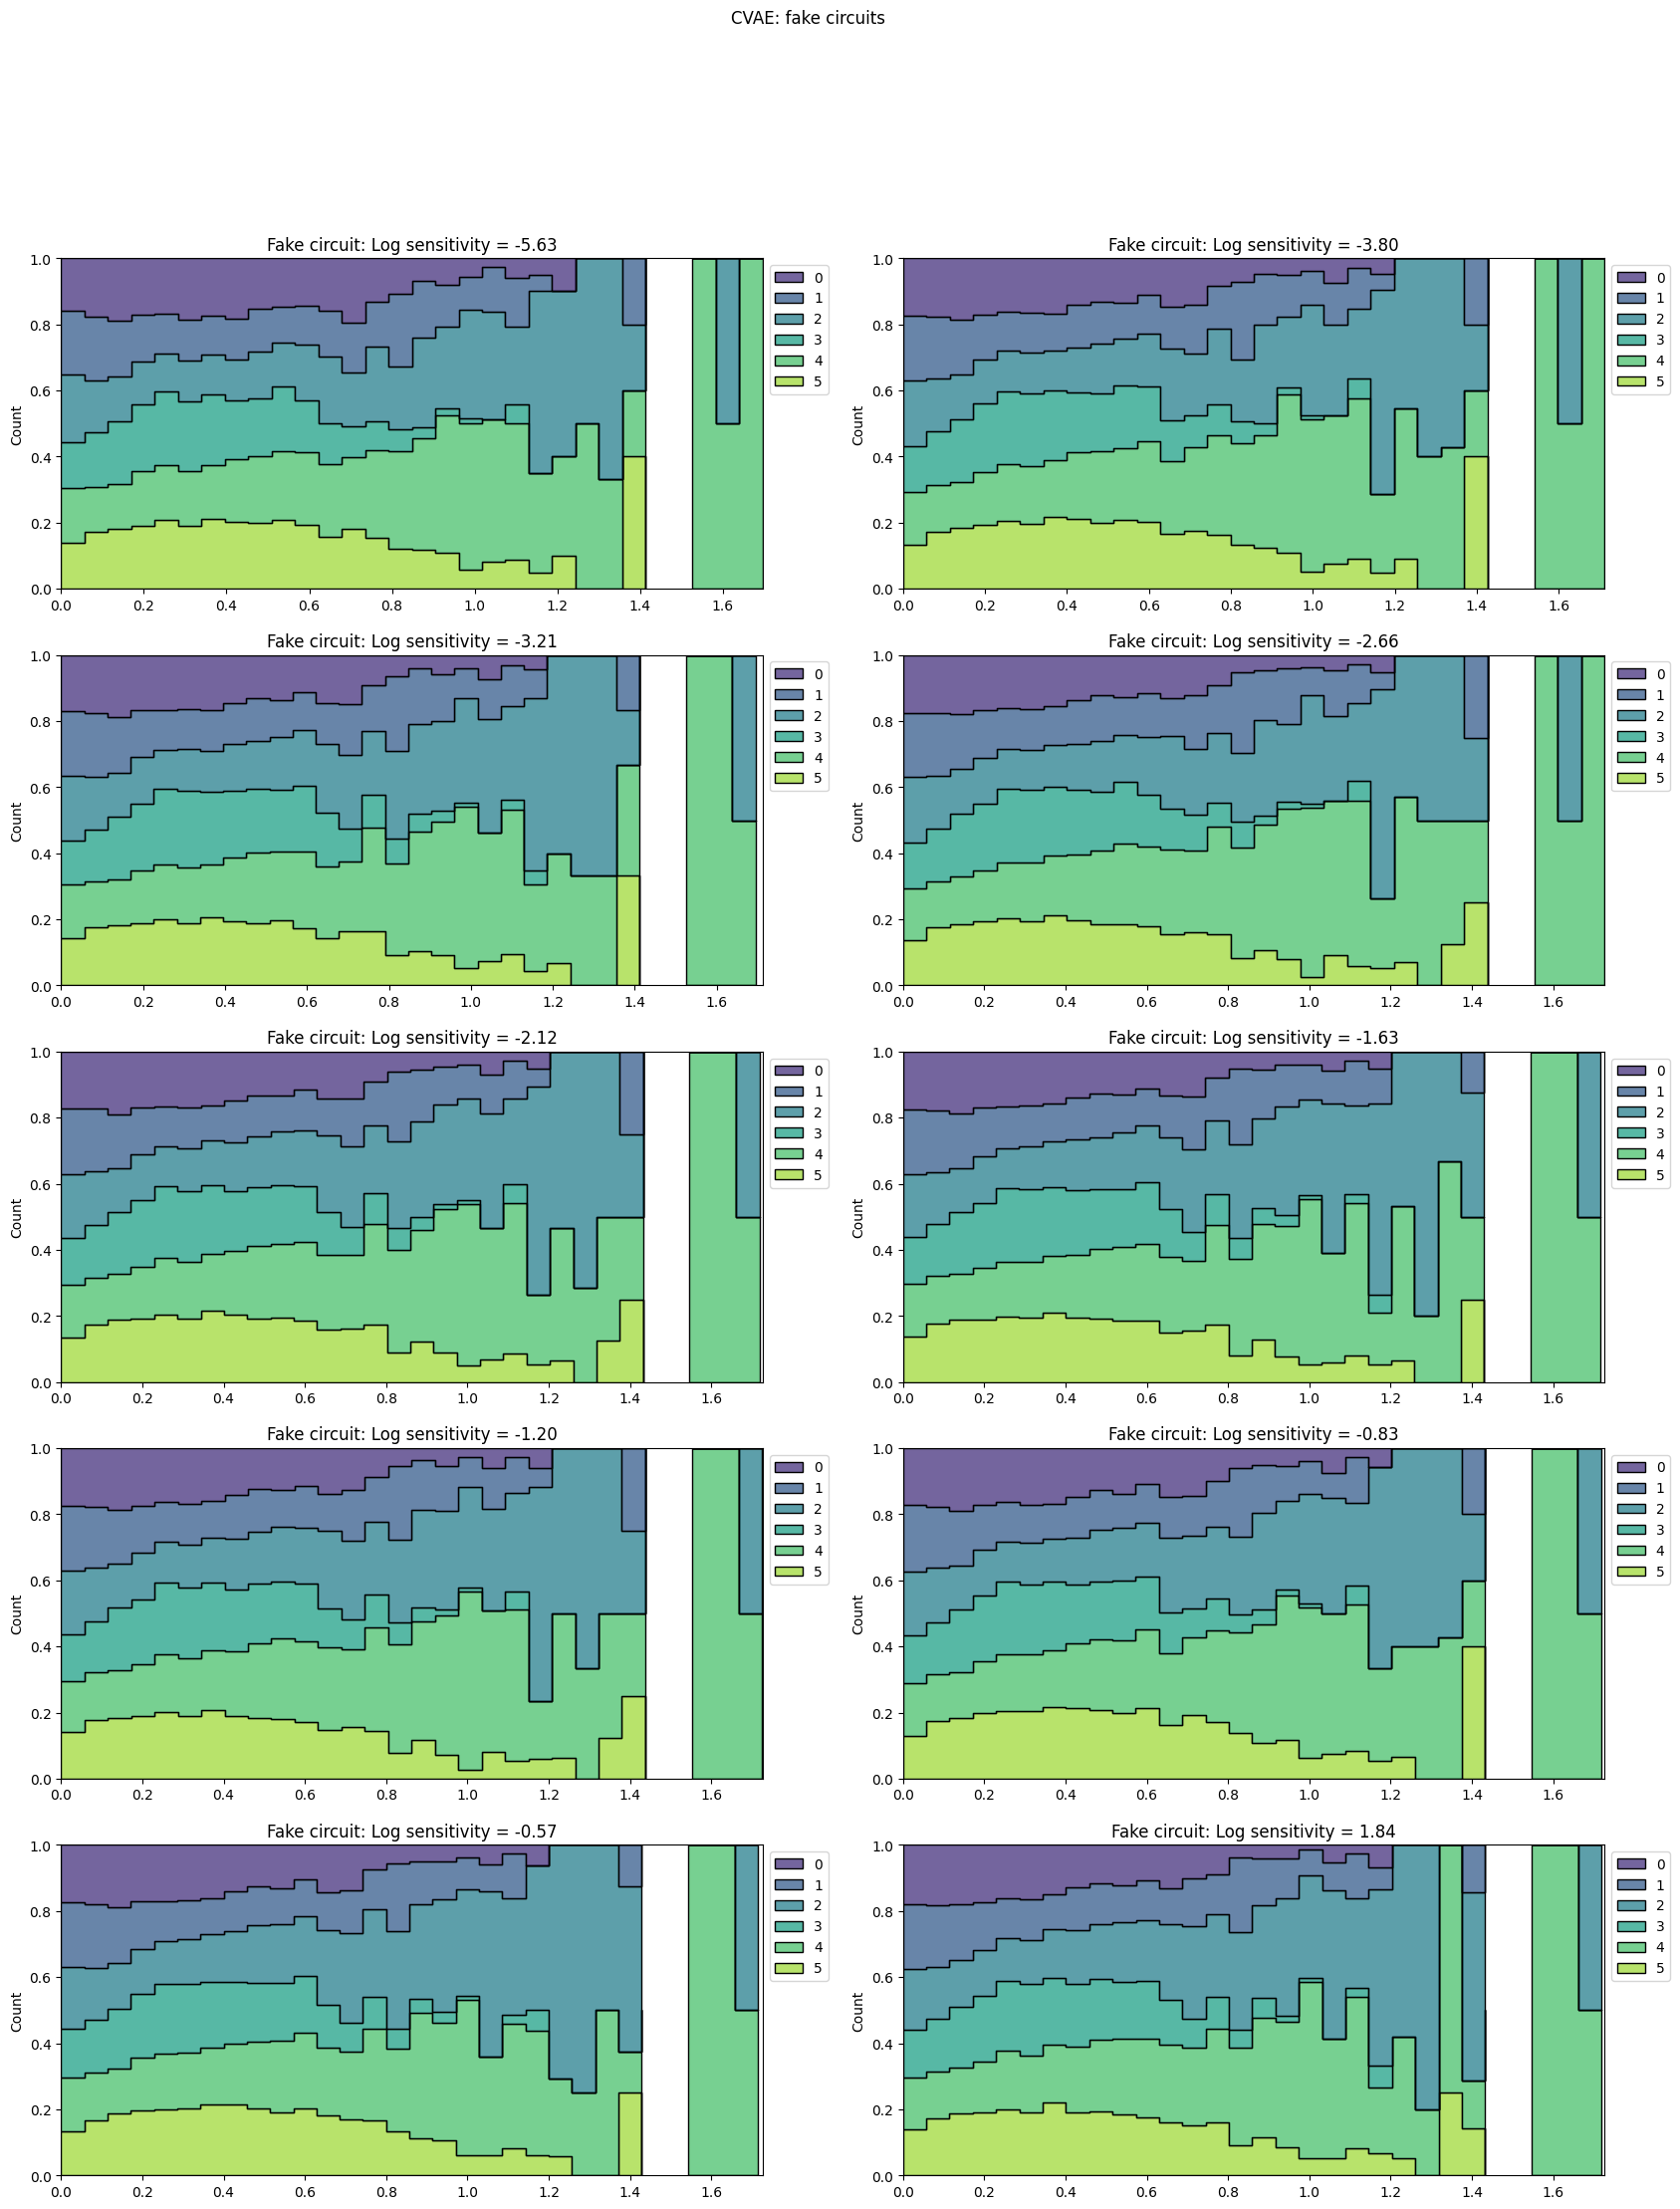

In [ ]:
fig = plt.figure(figsize=(10*2, 5*5))
show_max = 300 #n_to_sample
widest_lim = [0, 0]
for i, (zi, cat) in enumerate(zip(z, fake_circuits)):
    ax = plt.subplot(5, 2, i+1)
    # g = sns.scatterplot(cat[:show_max])
    g = sns.histplot(cat, element='step', bins=30, palette='viridis', multiple='fill')
    if PREP_Y_CATEGORICAL_ONEHOT:
        plt.title(f'Fake circuit: {OBJECTIVE_COL} = {y_datanormaliser.metadata["category_map"][i]:.2f}')
    else:
        plt.title(f'Fake circuit: {OBJECTIVE_COL} = {str(sorted(np.unique(sampled_cond))[i])[:6]}')
    sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
    widest_lim[0] = np.min([g.get_xlim()[0], widest_lim[0]])
    widest_lim[1] = np.max([g.get_xlim()[1], widest_lim[1]])
    g.set_xlim(widest_lim)

plt.suptitle(f'CVAE: fake circuits')

## Compare to real circuit's objective

In [ ]:
def apply_fns(x, fns: list):
    og_shape = x.shape
    if x.ndim > 2:
        x = x.reshape(*(np.prod(x.shape[:-1]), x.shape[-1]))
    for fcn in fns:
        x = fcn(x)
    return x.reshape(og_shape)

# df[OBJECTIVE_COL + '_nearest_edge'] = bin_to_nearest_edge(np.log10(df[OBJECTIVE_COL].to_numpy()), n_bins=n_categories)
# y_obj_all = df[OBJECTIVE_COL].to_numpy()
# for y_scale in y_scaling:
#     y_obj_all = y_scale(y_obj_all)
# df[OBJECTIVE_COL + '_nearest_edge'] = bin_to_nearest_edge(y_obj_all, n_bins=n_categories)
df = df[~df[OBJECTIVE_COL].isna()]
df[OBJECTIVE_COL + '_nearest_edge'] = bin_to_nearest_edge(df[OBJECTIVE_COL].to_numpy(), n_bins=n_categories)
fake_circuits = x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(fake_circuits)


In [ ]:
# fake_circuits = np.where(fake_circuits > df[X_COLS[0]].max().max(), df[X_COLS[0]].max().max(), fake_circuits)

Text(0.5, 0.98, 'CVAE: real circuits')

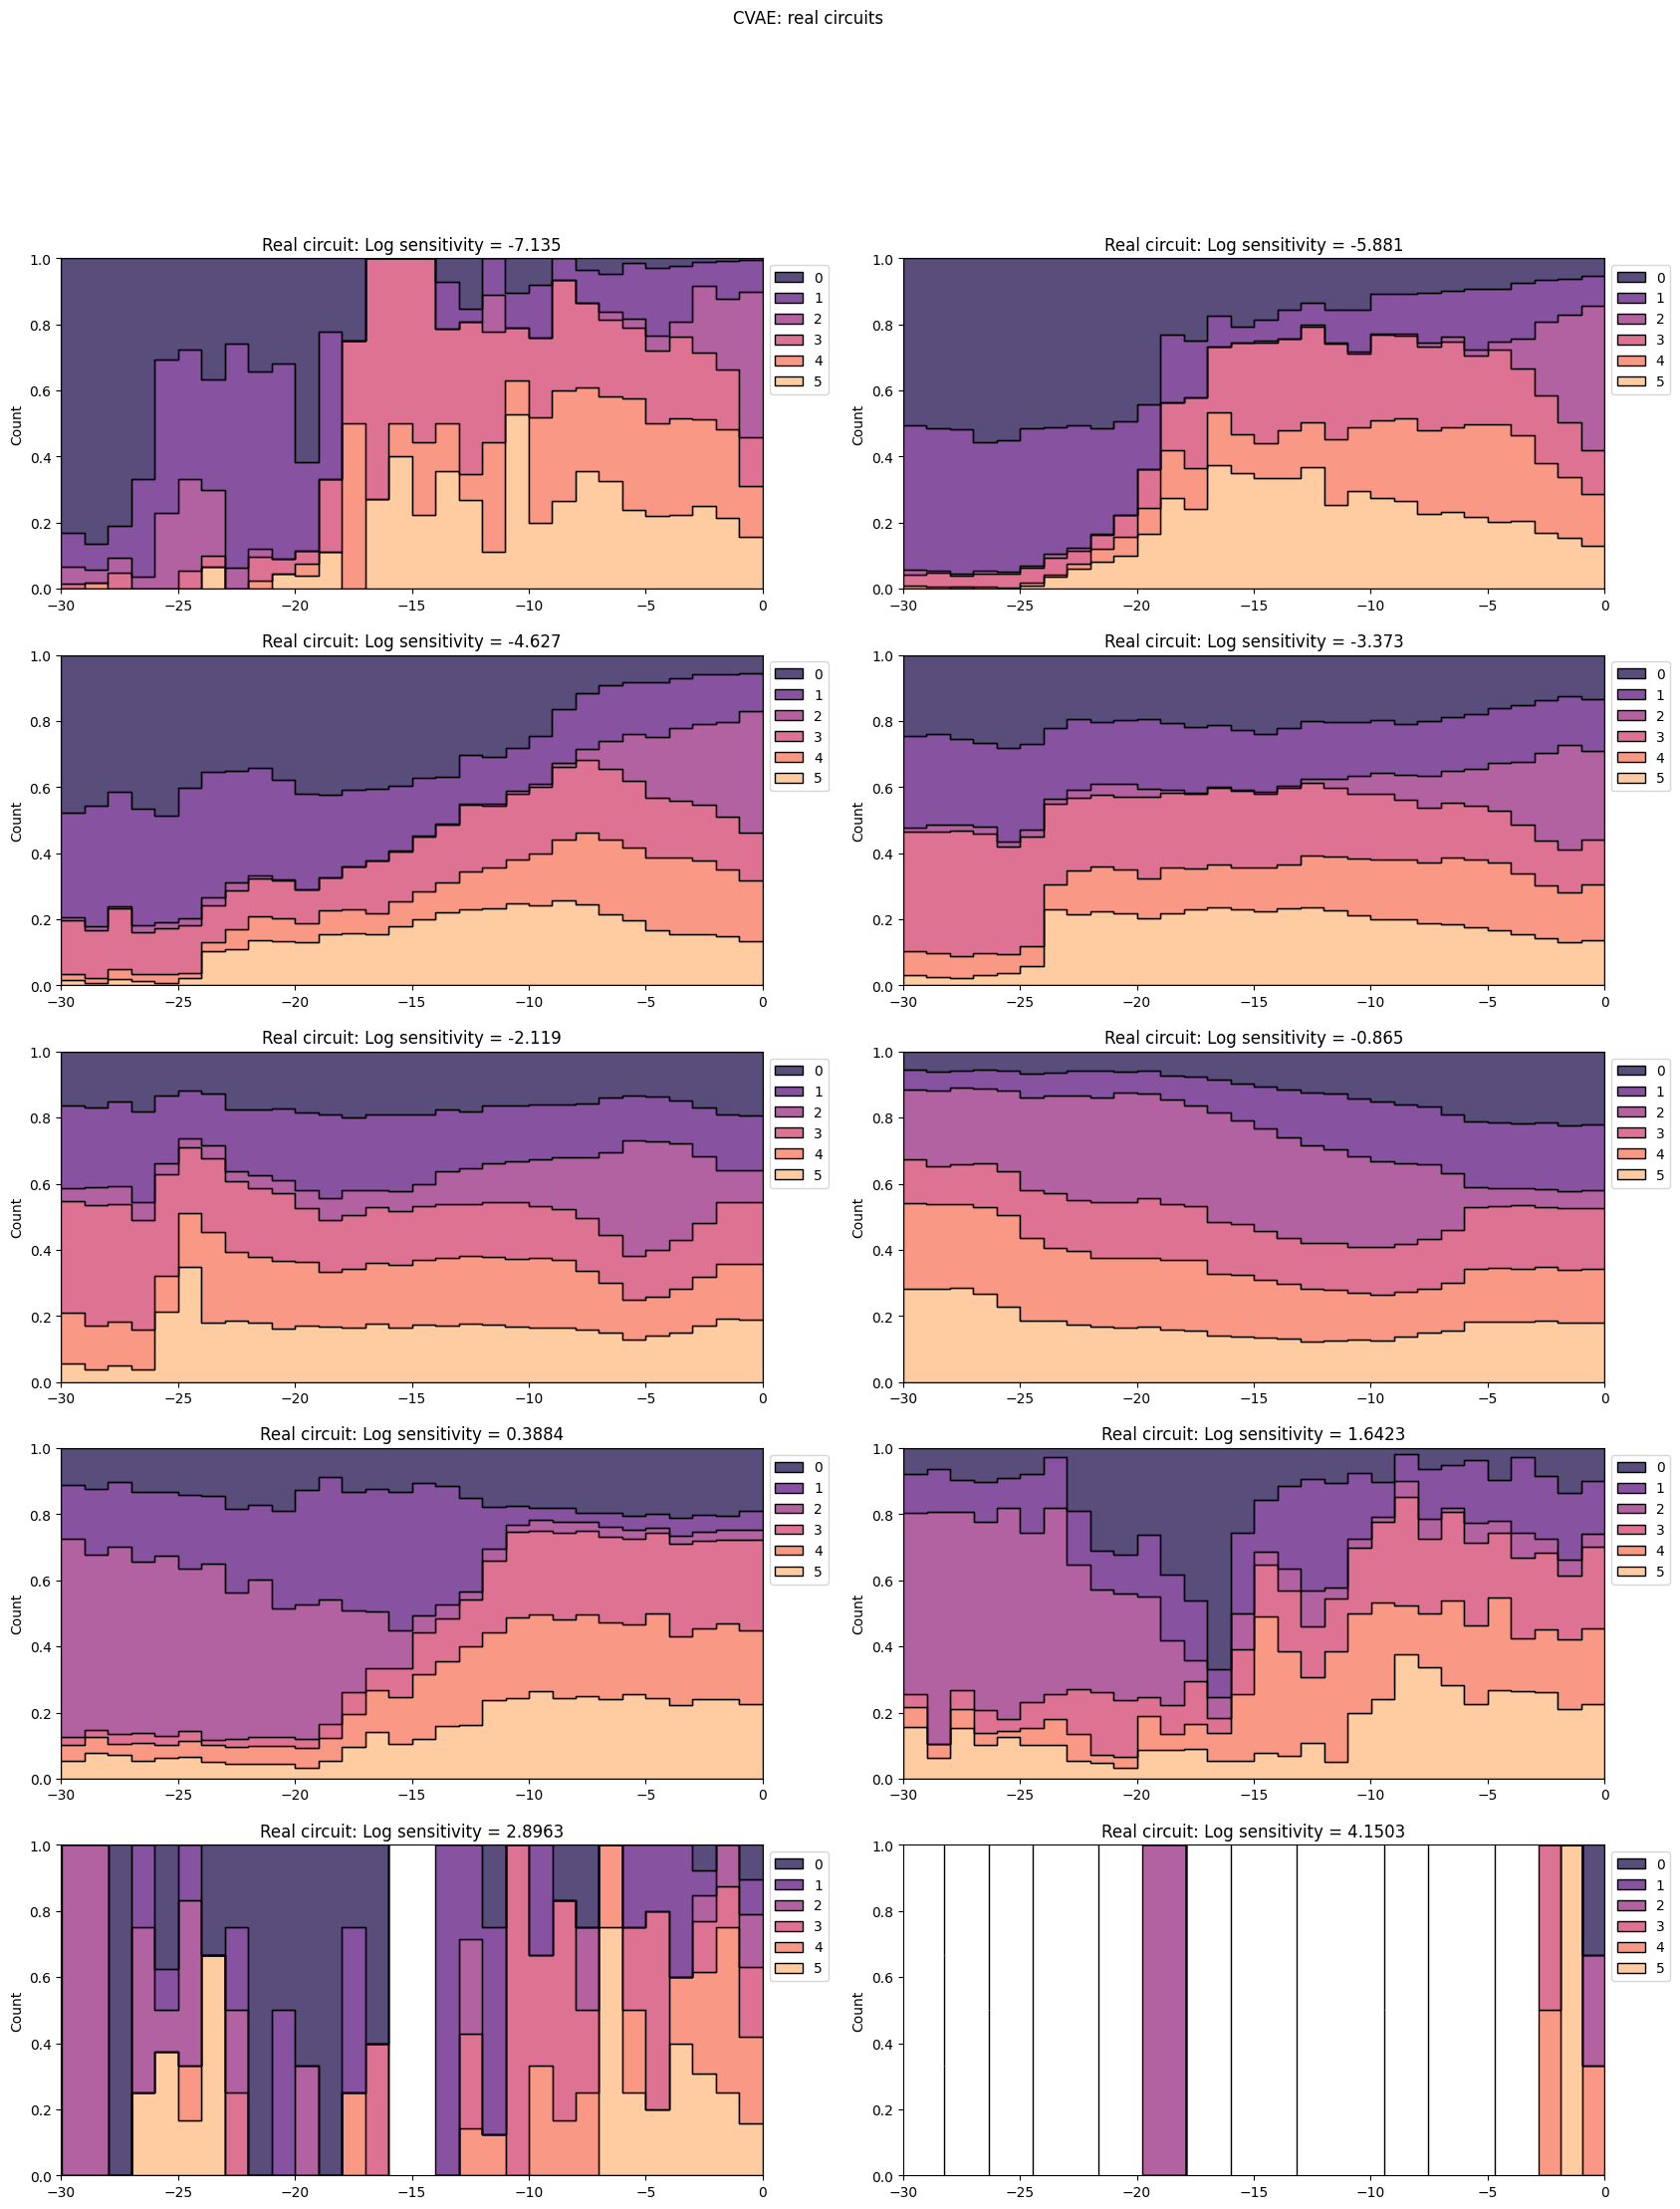

In [ ]:
fig = plt.figure(figsize=(10*2, 5*5))
show_max = 300 #n_to_sample
widest_lim = [0, 0]
for i, edge in enumerate(sorted(df[OBJECTIVE_COL + '_nearest_edge'].unique())):
    cat = df[df[OBJECTIVE_COL + '_nearest_edge'] == edge]
    cat = cat[X_COLS].to_numpy()
    
    ax = plt.subplot(5, 2, i+1)
    # g = sns.scatterplot(cat[:show_max])
    g = sns.histplot(cat, element='step', bins=30, palette='magma', multiple='fill')
    plt.title(f'Real circuit: {OBJECTIVE_COL} = {str(edge)[:6]}')
    sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
    widest_lim[0] = np.min([g.get_xlim()[0], widest_lim[0]])
    widest_lim[1] = np.max([g.get_xlim()[1], widest_lim[1]])
    g.set_xlim(widest_lim)

plt.suptitle(f'CVAE: real circuits')

## Combined

Text(0.5, 0.98, 'CVAE: circuit comparison fake vs. real')

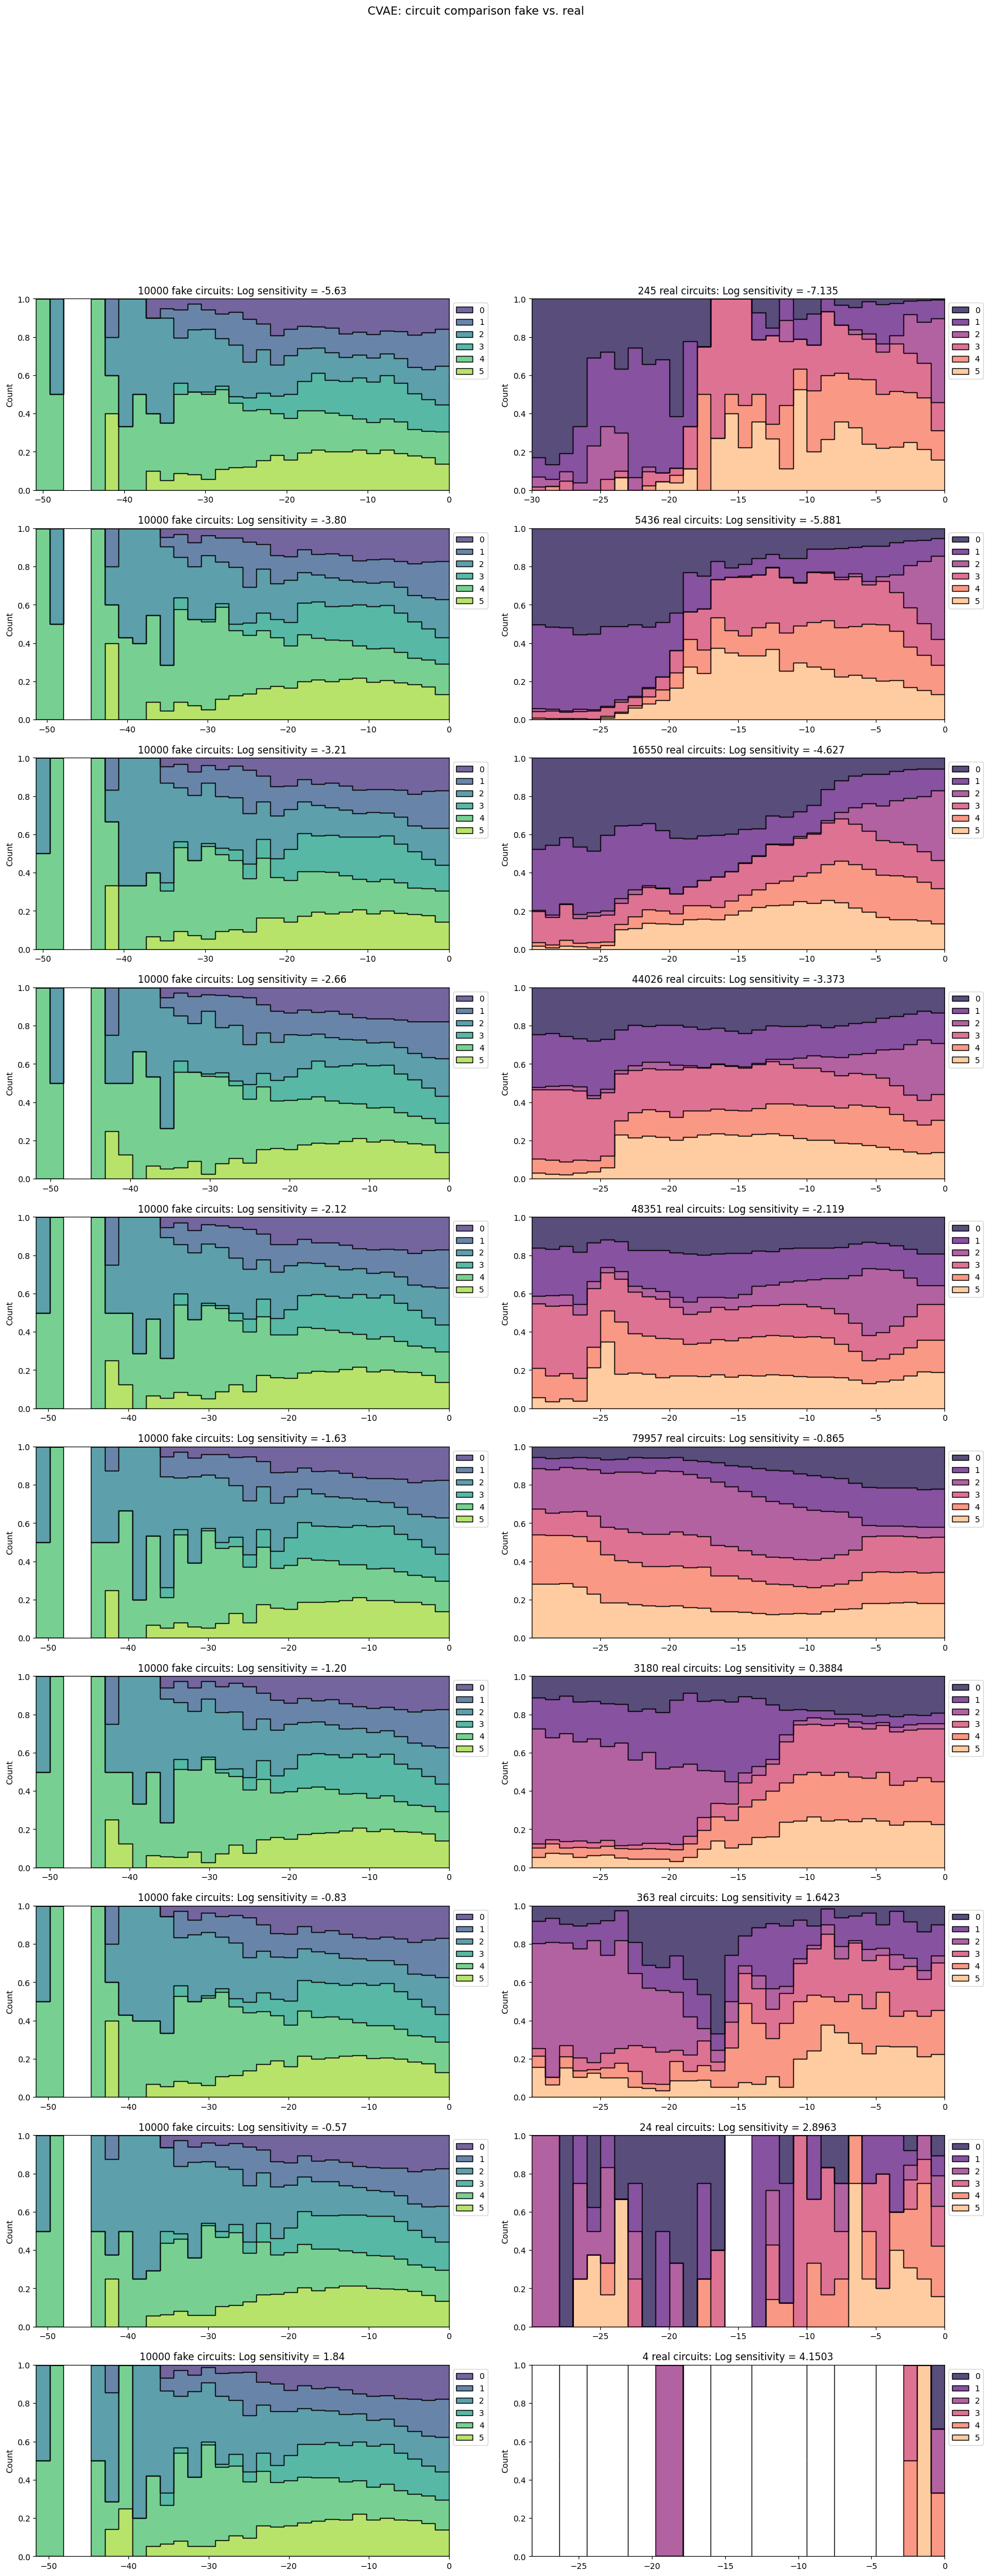

In [ ]:
fig = plt.figure(figsize=(10*2, n_categories*5))
show_max = 300 #n_to_sample
for i, (zi, fake, edge) in enumerate(zip(z, fake_circuits, sorted(df[OBJECTIVE_COL + '_nearest_edge'].unique()))):
    widest_lim = [0, 0]
    real = df[df[OBJECTIVE_COL + '_nearest_edge'] == edge][X_COLS].to_numpy()
    
    ax = plt.subplot(n_categories, 2, 2*i+1)
    # g = sns.scatterplot(cat[:show_max])
    g1 = sns.histplot(fake, element='step', bins=30, palette='viridis', multiple='fill')
    sc = np.array(sorted(np.unique(sampled_cond)))[:, None]
    sc = y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(sc)
    # plt.title(f'{len(fake)} fake circuits: {OBJECTIVE_COL} = {str(sc.flatten()[i])[:6]}')
    if PREP_Y_CATEGORICAL_ONEHOT:
        plt.title(f'{len(fake)} fake circuits: {OBJECTIVE_COL} = {y_datanormaliser.metadata["category_map"][i]:.2f}')
    else:
        plt.title(f'{len(fake)} fake circuits: {OBJECTIVE_COL} = {str(sc.flatten()[i])[:6]}')
    sns.move_legend(g1, 'upper left', bbox_to_anchor=(1, 1))
    
    ax = plt.subplot(n_categories, 2, 2*i+2)
    # g = sns.scatterplot(cat[:show_max])
    g2 = sns.histplot(real, element='step', bins=30, palette='magma', multiple='fill')
    plt.title(f'{len(real)} real circuits: {OBJECTIVE_COL} = {str(edge)[:6]}')
    sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))
    
    widest_lim = [np.min([g1.get_xlim()[0], g2.get_xlim()[0], widest_lim[0]]), np.max([g1.get_xlim()[1], g2.get_xlim()[1], widest_lim[1]])]
    # g1.set_xlim(widest_lim)
    # g2.set_xlim(widest_lim)


plt.suptitle(f'CVAE: circuit comparison fake vs. real', fontsize=14)

Text(0.5, 0.98, 'CVAE: circuit comparison fake vs. real')

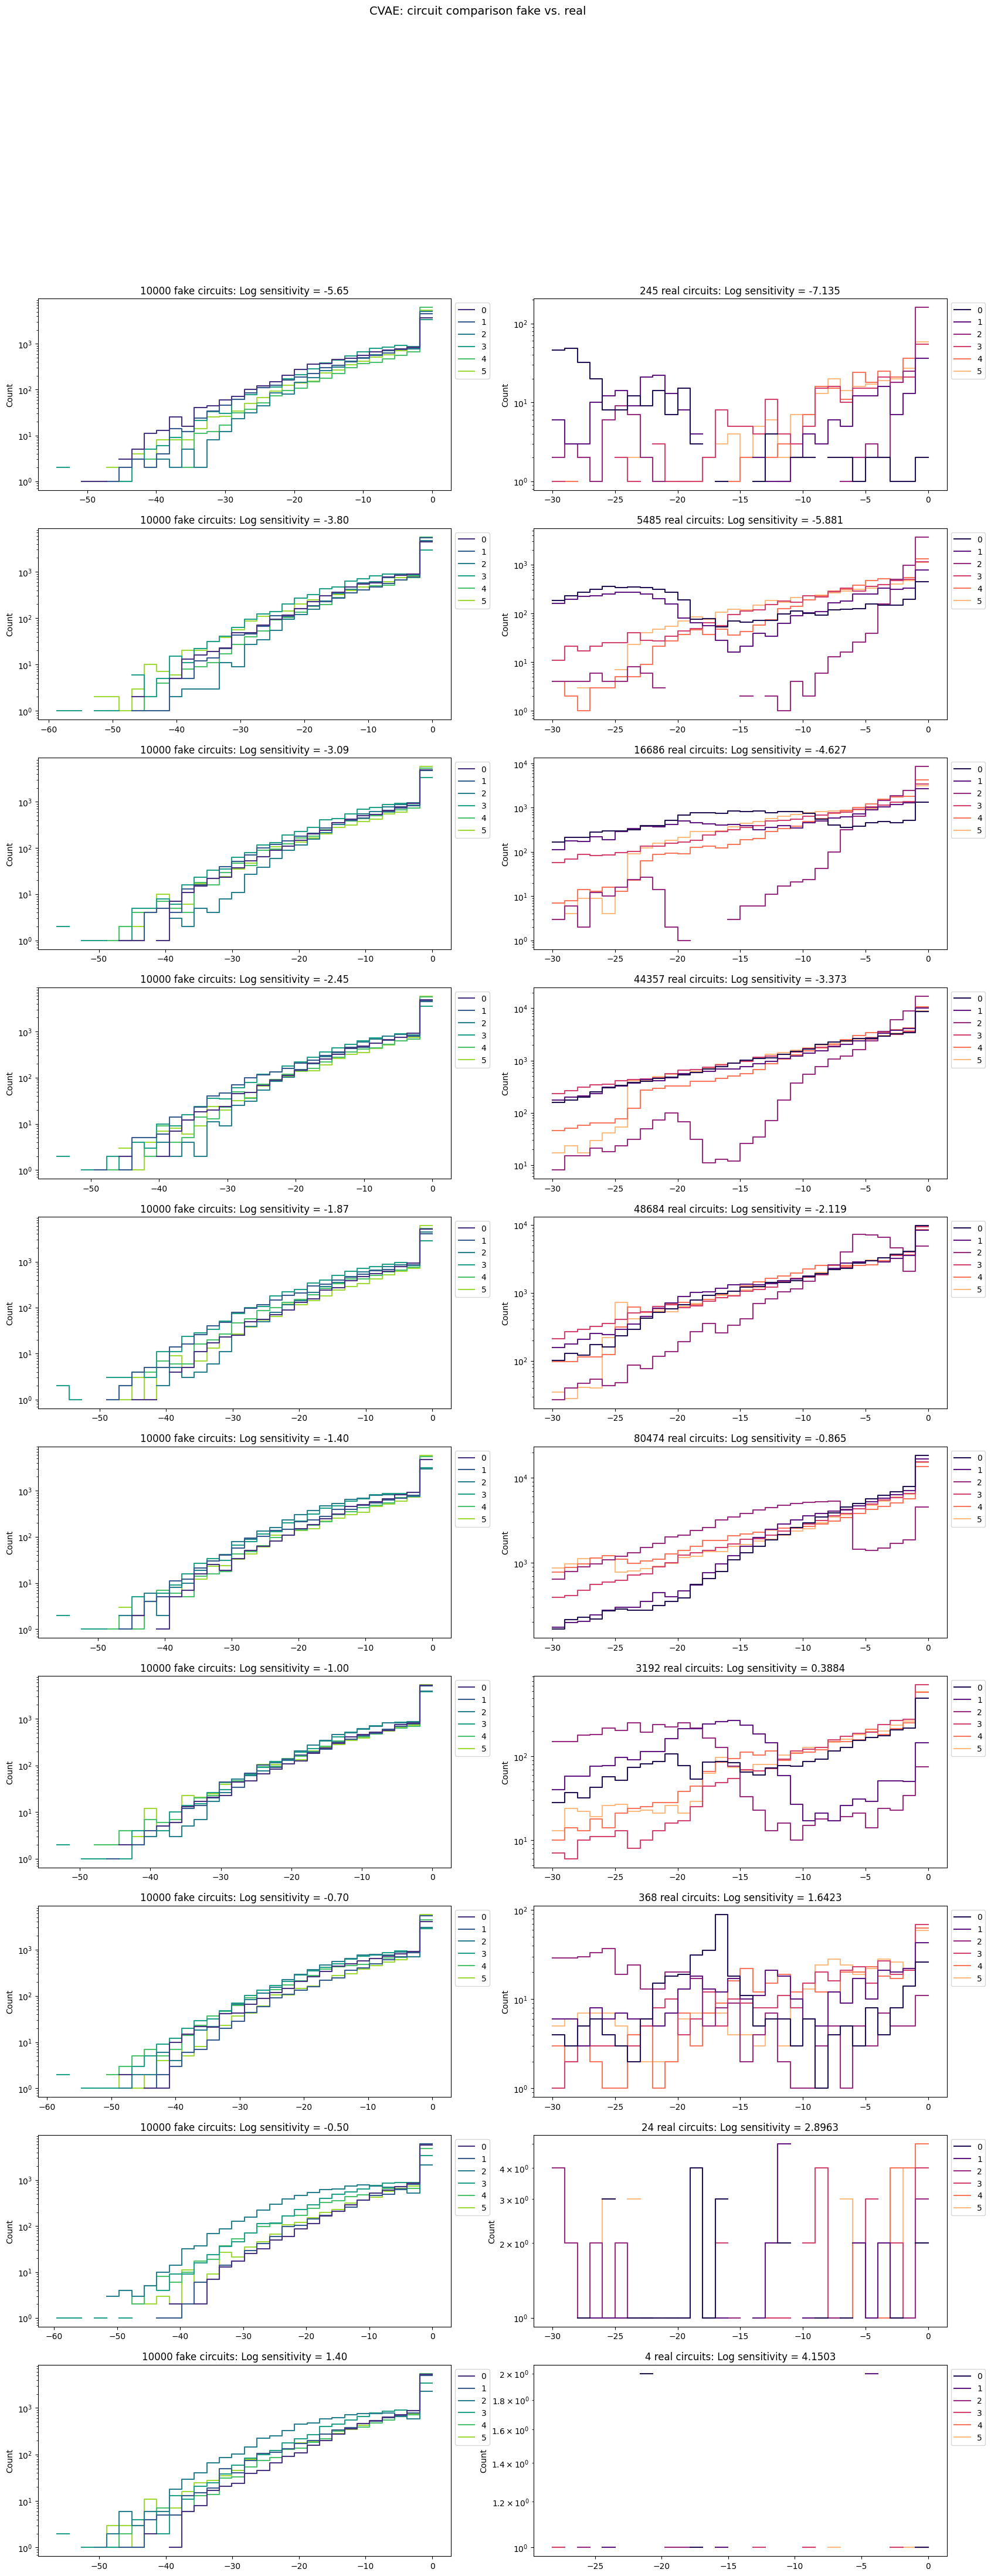

In [ ]:
fig = plt.figure(figsize=(10*2, n_categories*5))
show_max = 300 #n_to_sample
for i, (zi, fake, edge) in enumerate(zip(z, fake_circuits, sorted(df[OBJECTIVE_COL + '_nearest_edge'].unique()))):
    real = df[df[OBJECTIVE_COL + '_nearest_edge'] == edge][X_COLS].to_numpy()
    
    ax = plt.subplot(n_categories, 2, 2*i+1)
    # g = sns.scatterplot(cat[:show_max])
    g1 = sns.histplot(fake, element='step', bins=30, palette='viridis', multiple='layer', fill=False, log_scale=[False, True])
    sc = np.array(sorted(np.unique(sampled_cond)))[:, None]
    sc = y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(sc)
    if PREP_Y_CATEGORICAL_ONEHOT:
        plt.title(f'{len(fake)} fake circuits: {OBJECTIVE_COL} = {y_datanormaliser.metadata["category_map"][i]:.2f}')
    else:
        plt.title(f'{len(fake)} fake circuits: {OBJECTIVE_COL} = {str(sc.flatten()[i])[:6]}')
    sns.move_legend(g1, 'upper left', bbox_to_anchor=(1, 1))
    
    ax = plt.subplot(n_categories, 2, 2*i+2)
    # g = sns.scatterplot(cat[:show_max])
    g2 = sns.histplot(real, element='step', bins=30, palette='magma', multiple='layer', fill=False, log_scale=[False, True])
    plt.title(f'{len(real)} real circuits: {OBJECTIVE_COL} = {str(edge)[:6]}')
    sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))
    
    widest_xlim = [np.min([g1.get_xlim()[0], g2.get_xlim()[0]]), np.max([g1.get_xlim()[1], g2.get_xlim()[1]])]
    widest_ylim = [np.min([g1.get_ylim()[0], g2.get_ylim()[0]]), np.max([g1.get_ylim()[1], g2.get_ylim()[1]])]
    # g1.set_xlim(widest_xlim)
    # g2.set_ylim(widest_ylim)


plt.suptitle(f'CVAE: circuit comparison fake vs. real', fontsize=14)